# GCP VM PRICING - DATA SCIENCE PROJECT

## Objectif Métier
Prédire et analyser les coûts des machines virtuelles GCP pour optimiser les décisions d'achat et de configuration.

## Approches
1. **REGRESSION**: Prédire le coût mensuel estimé (monthly_cost_estimate_usd)
2. **CLASSIFICATION**: Classifier les VMs par catégorie de prix (bas/moyen/élevé)
3. **CLUSTERING**: Grouper les VMs similaires pour segmentation
4. **RECOMMENDATION (Clustering + Classification)**: Recommander des VMs similaires basées sur le clustering et la classification
5. **ANALYSE SENTIMENTALE (Naive Bayes)**: Analyser le sentiment (positif/négatif/neutre) basé sur les caractéristiques et le rapport qualité/prix

---


## SECTION 1: INSTALLATION & IMPORTS


In [52]:
!pip install pandas numpy matplotlib seaborn scikit-learn xgboost -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                            accuracy_score, classification_report, confusion_matrix,
                            adjusted_rand_score)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All imports successful!")


All imports successful!


## SECTION 2: DATA LOADING AND INITIAL EXPLORATION


In [53]:
print("="*80)
print("SECTION 2: DATA LOADING AND INITIAL EXPLORATION")
print("="*80)

df = pd.read_csv('C:\\Users\\talel\\StudioProjects\\untitled\\gcp_vm_pricing_raw_dirty_12k.csv')

print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {len(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()


SECTION 2: DATA LOADING AND INITIAL EXPLORATION

Dataset Shape: (12360, 35)
Columns: 35

First 5 rows:


,sku_id,machine_family,machine_type,vcpus,memory,cpu_arch,region,region_code,zone,os,...,gpu_count,gpu_hourly_usd,egress_destination,egress_gb,egress_unit_price_usd,billing_frequency,usage_hours_month,monthly_cost_estimate_usd,price_source,feedback
0,SKU-C52944DC25D9,c2,c2-highcpu-32,32 vCPU,32GIB,X86-64,Us West1,us-west1,Us West1 C,Windows Server 2019,...,NaN,0,same-region,up to 500GB,0.01 USD/GB,per-second,686,$1365.08,Pricing API,"Average pricing, acceptable for standard workl..."
1,SKU-E30B5875126A,t2d,t2d-standard-96,96,384,arm64,US East (N. Virginia),us_east4,us-east4-c,Linux,...,0.0,0,australia,50,0.1973,per_second,720,$2860.49,Manual,"Fair price point, meets expectations"
2,SKU-AE187D8090D8,c2,c2-standard-32,32,128 GB,x86_64,Asia Northeast1,asia_northeast1,asia-northeast1-a,Linux,...,2.0,6.7650 USD,intercontinental,200,0.1193,per_second,720,NaN,Manual,Not cost-effective for our needs
3,SKU-9E3422759B52,a2,a2-highcpu-96,96vcpus,192 GB,arm64,southamerica-east1,southamerica_east1,Southamerica East1 E,Windows Server 2022,...,1.0,0.6132,same-continent,up to 10GB,0.0816,per-second,730,NaN,Manual,"Fair price point, meets expectations"
4,SKU-8019156735CD,n2d,N2D HIGHCPU 2,2,2 GB,x86_64,NORTHAMERICA-NORTHEAST1,northamerica_northeast1,northamerica-northeast1-c,RHEL,...,NaN,0,china,1000,$0.230/GB,hourly,380,272.69,Calculator,"Average cost, meets basic requirements"


In [54]:
print(f"\nData Types:")
print(df.dtypes)

print(f"\nMissing Values:")
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))

print(f"\nBasic Statistics:")
df.describe(include='all')



Data Types:
sku_id                              object
machine_family                      object
machine_type                        object
vcpus                               object
memory                              object
cpu_arch                            object
region                              object
region_code                         object
zone                                object
os                                  object
network_tier                        object
price_model                         object
on_demand_hourly_usd                object
spot_hourly_usd                     object
sustained_use_discount_eligible     object
cud_1yr_discount                    object
cud_3yr_discount                    object
preemptible_available               object
effective_date                      object
currency                            object
boot_disk_type                      object
boot_disk_gb                        object
local_ssd_count                      int6

,sku_id,machine_family,machine_type,vcpus,memory,cpu_arch,region,region_code,zone,os,...,gpu_count,gpu_hourly_usd,egress_destination,egress_gb,egress_unit_price_usd,billing_frequency,usage_hours_month,monthly_cost_estimate_usd,price_source,feedback
count,12360,12360,12360,12360,12360,12360,12360,12360,12360,12360,...,9045.000000,8950,12360,12360,12360,12360,11543,8971,12360,12360
unique,12000,16,1476,21,263,3,139,42,530,6,...,NaN,2126,5,12,1634,5,594,8671,4,45
top,SKU-6BD61A889B46,c2,c3-highcpu-2,96,64,arm64,asia-east1,us_west1,europe-north1-b,Windows Server 2019,...,NaN,0,same-region,100,0.01 USD/GB,per_second,730,$518.60,Manual,Standard pricing structure
freq,2,1367,61,926,944,4142,408,333,111,2101,...,NaN,6733,2537,1411,503,2541,3766,3,3121,308
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.487452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.043812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## SECTION 3: DATA CLEANING

### 3.1: Clean Numeric Columns


In [55]:
print("="*80)
print("SECTION 3: DATA CLEANING")
print("="*80)

df_clean = df.copy()

print("\n Cleaning numeric columns...")

numeric_columns = ['on_demand_hourly_usd', 'spot_hourly_usd', 'cud_1yr_discount',
                   'cud_3yr_discount', 'gpu_hourly_usd', 'egress_unit_price_usd',
                   'monthly_cost_estimate_usd', 'usage_hours_month', 'boot_disk_gb',
                   'local_ssd_total_gb', 'egress_gb', 'vcpus', 'memory']

for col in numeric_columns:
    if col in df_clean.columns:
        # Remove $, commas, and convert to float
        df_clean[col] = df_clean[col].astype(str).str.replace('$', '', regex=False)
        df_clean[col] = df_clean[col].str.replace(',', '', regex=False)
        df_clean[col] = df_clean[col].str.replace(' ', '', regex=False)
        # Convert to numeric, errors='coerce' will turn invalid to NaN
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Convert memory from string (e.g., "16 GB") to numeric GB
if 'memory' in df_clean.columns:
    df_clean['memory_gb'] = df_clean['memory'].astype(str).str.extract(r'(\d+\.?\d*)')[0]
    df_clean['memory_gb'] = pd.to_numeric(df_clean['memory_gb'], errors='coerce')
    df_clean = df_clean.drop('memory', axis=1)

# Convert vcpus to numeric
if 'vcpus' in df_clean.columns:
    df_clean['vcpus'] = pd.to_numeric(df_clean['vcpus'], errors='coerce')

print("Numeric columns cleaned!")


SECTION 3: DATA CLEANING

 Cleaning numeric columns...
Numeric columns cleaned!


### 3.2: Handle Missing Values


In [56]:
print("\nHandling missing values...")

initial_rows = len(df_clean)
df_clean = df_clean.dropna(subset=['monthly_cost_estimate_usd'])
print(f"   Dropped {initial_rows - len(df_clean)} rows with missing target variable")

numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if df_clean[col].isnull().sum() > 0:
        median_val = df_clean[col].median()
        df_clean[col].fillna(median_val, inplace=True)
        print(f"   Filled {col} with median: {median_val:.2f}")

categorical_cols = df_clean.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df_clean[col].isnull().sum() > 0:
        mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
        df_clean[col].fillna(mode_val, inplace=True)
        print(f"   Filled {col} with mode: {mode_val}")

print(f"\nMissing values handled! Remaining: {df_clean.isnull().sum().sum()}")



Handling missing values...
   Dropped 6409 rows with missing target variable
   Filled vcpus with median: 16.00
   Filled on_demand_hourly_usd with median: 1.97
   Filled spot_hourly_usd with median: 0.51
   Filled cud_1yr_discount with median: 0.25
   Filled cud_3yr_discount with median: 0.50
   Filled boot_disk_gb with median: 25.00
   Filled local_ssd_total_gb with median: 0.00
   Filled gpu_count with median: 0.00
   Filled gpu_hourly_usd with median: 0.00
   Filled egress_gb with median: 200.00
   Filled egress_unit_price_usd with median: 0.12
   Filled usage_hours_month with median: 720.00
   Filled memory_gb with median: 64.00
   Filled sustained_use_discount_eligible with mode: False
   Filled preemptible_available with mode: False
   Filled gpu_model with mode: NVIDIA_K80

Missing values handled! Remaining: 0


### 3.3: Feature Engineering


In [57]:
print("\nFeature engineering...")

if 'sustained_use_discount_eligible' in df_clean.columns:
    df_clean['sustained_use_discount'] = (df_clean['sustained_use_discount_eligible'] == 'Yes').astype(int)

if 'preemptible_available' in df_clean.columns:
    df_clean['preemptible'] = (df_clean['preemptible_available'] == 'Yes').astype(int)

df_clean['cost_per_vcpu'] = df_clean['monthly_cost_estimate_usd'] / (df_clean['vcpus'] + 1e-6)

df_clean['cost_per_gb_memory'] = df_clean['monthly_cost_estimate_usd'] / (df_clean['memory_gb'] + 1e-6)

df_clean['has_gpu'] = (df_clean['gpu_count'] > 0).astype(int)
df_clean['gpu_count'] = df_clean['gpu_count'].fillna(0)

df_clean['has_local_ssd'] = (df_clean['local_ssd_count'] > 0).astype(int)

print(f"   Created new features: sustained_use_discount, preemptible, cost_per_vcpu, etc.")
print(f"\nData cleaning complete! Final shape: {df_clean.shape}")



Feature engineering...
   Created new features: sustained_use_discount, preemptible, cost_per_vcpu, etc.

Data cleaning complete! Final shape: (5951, 41)


## SECTION 3.5: DATA BALANCING

### 3.5.1: Check Class Distribution


SECTION 3.5: DATA BALANCING

Creating classification target to check distribution...

Class Distribution (Before Balancing):
price_category
Low       1964
Medium    1964
High      2023
Name: count, dtype: int64

Class Percentages:
   Low: 1964 (33.00%)
   Medium: 1964 (33.00%)
   High: 2023 (33.99%)


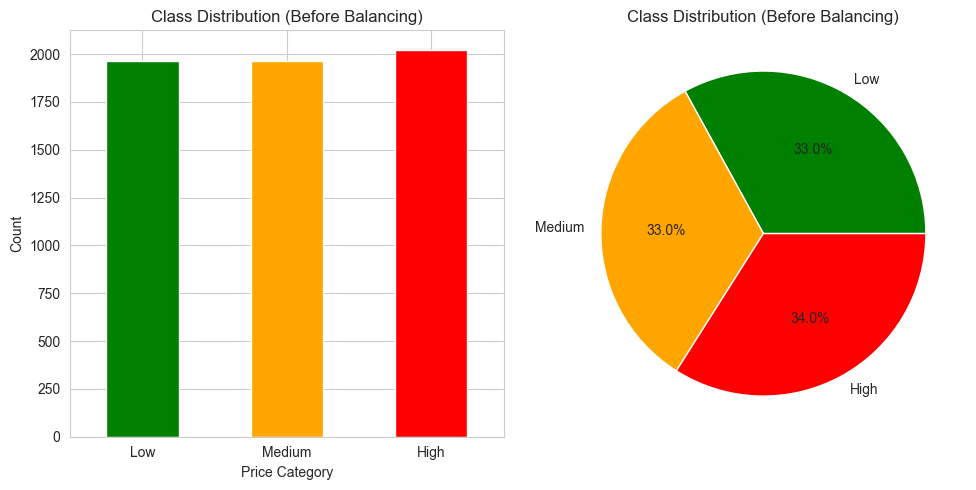


Imbalance Ratio (max/min): 1.03
   ✓ Classes are relatively balanced.


In [58]:
print("="*80)
print("SECTION 3.5: DATA BALANCING")
print("="*80)

# First, create the classification target to check distribution
print("\nCreating classification target to check distribution...")
price_quantiles = df_clean['monthly_cost_estimate_usd'].quantile([0.33, 0.66])
df_clean['price_category'] = pd.cut(
    df_clean['monthly_cost_estimate_usd'],
    bins=[0, price_quantiles[0.33], price_quantiles[0.66], float('inf')],
    labels=['Low', 'Medium', 'High']
)

# Check class distribution
print("\nClass Distribution (Before Balancing):")
class_counts = df_clean['price_category'].value_counts().sort_index()
print(class_counts)
print("\nClass Percentages:")
for category, count in class_counts.items():
    pct = count / len(df_clean) * 100
    print(f"   {category}: {count} ({pct:.2f}%)")

# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
class_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Class Distribution (Before Balancing)')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'orange', 'red'])
plt.title('Class Distribution (Before Balancing)')
plt.ylabel('')

plt.tight_layout()
plt.show()

# Check if classes are imbalanced
max_count = class_counts.max()
min_count = class_counts.min()
imbalance_ratio = max_count / min_count

print(f"\nImbalance Ratio (max/min): {imbalance_ratio:.2f}")
if imbalance_ratio > 1.5:
    print("   ⚠️  Class imbalance detected! Balancing recommended.")
else:
    print("   ✓ Classes are relatively balanced.")


### 3.5.2: Apply SMOTE for Balancing



--------------------------------------------------------------------------------
3.5.2: APPLYING SMOTE FOR DATA BALANCING
--------------------------------------------------------------------------------
   imbalanced-learn already installed

Preparing features for SMOTE...
   Using 18 numeric features for balancing
   Original dataset shape: (5951, 18)
   Original class distribution: [2023 1964 1964]

Applying SMOTE to balance classes...
   Balanced dataset shape: (6069, 18)
   Balanced class distribution: [2023 2023 2023]

Creating balanced dataframe...
   Adding back categorical features...

Updating df_clean with balanced data...

✓ Data balancing complete!
   Original dataset size: 5951
   Balanced dataset size: 6069
   Increase: 118 samples (2.0%)

Class Distribution (After Balancing):
price_category
High      2023
Low       2023
Medium    2023
Name: count, dtype: int64

Class Percentages (After Balancing):
   High: 2023 (33.33%)
   Low: 2023 (33.33%)
   Medium: 2023 (33.33%)


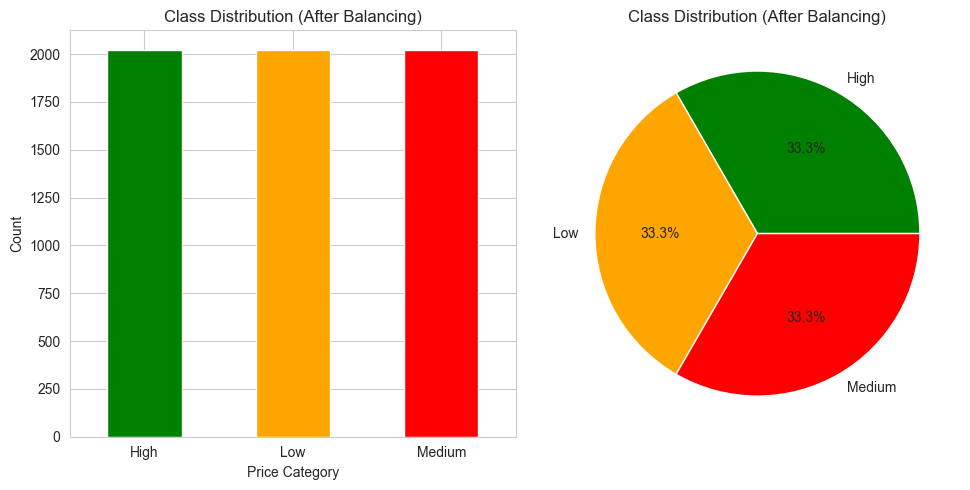


DATA BALANCING COMPLETE


In [59]:
print("\n" + "-"*80)
print("3.5.2: APPLYING SMOTE FOR DATA BALANCING")
print("-"*80)

# Install imbalanced-learn if not already installed
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.combine import SMOTETomek
    print("   imbalanced-learn already installed")
except ImportError:
    print("   Installing imbalanced-learn...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'imbalanced-learn', '-q'])
    from imblearn.over_sampling import SMOTE
    from imblearn.combine import SMOTETomek
    print("   imbalanced-learn installed successfully")

# Prepare features for balancing
# We need to encode categorical variables first for SMOTE
print("\nPreparing features for SMOTE...")

# Select numeric features only (SMOTE works best with numeric features)
numeric_features_for_balancing = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Remove target variables and derived features
exclude_cols = ['monthly_cost_estimate_usd', 'price_category', 
                'cost_per_vcpu', 'cost_per_gb_memory']
numeric_features_for_balancing = [col for col in numeric_features_for_balancing 
                                  if col not in exclude_cols]

print(f"   Using {len(numeric_features_for_balancing)} numeric features for balancing")

# Prepare X and y for balancing
X_balance = df_clean[numeric_features_for_balancing].values
y_balance = LabelEncoder().fit_transform(df_clean['price_category'])

print(f"   Original dataset shape: {X_balance.shape}")
print(f"   Original class distribution: {np.bincount(y_balance)}")

# Apply SMOTE
print("\nApplying SMOTE to balance classes...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X_balance, y_balance)

print(f"   Balanced dataset shape: {X_balanced.shape}")
print(f"   Balanced class distribution: {np.bincount(y_balanced)}")

# Create balanced dataframe
print("\nCreating balanced dataframe...")
df_balanced = pd.DataFrame(X_balanced, columns=numeric_features_for_balancing)

# Add back the price category
label_encoder = LabelEncoder()
label_encoder.fit(df_clean['price_category'])
df_balanced['price_category'] = label_encoder.inverse_transform(y_balanced)

# Reconstruct monthly_cost_estimate_usd from price category (approximate)
# We'll use the median of each category
category_medians = df_clean.groupby('price_category')['monthly_cost_estimate_usd'].median()
for category in ['Low', 'Medium', 'High']:
    mask = df_balanced['price_category'] == category
    # Use a distribution around the median for more realistic values
    median_val = category_medians[category]
    # Sample from original distribution of that category
    original_values = df_clean[df_clean['price_category'] == category]['monthly_cost_estimate_usd'].values
    if len(original_values) > 0:
        # Randomly sample from original values for this category
        np.random.seed(42)
        sampled_values = np.random.choice(original_values, size=mask.sum(), replace=True)
        df_balanced.loc[mask, 'monthly_cost_estimate_usd'] = sampled_values
    else:
        df_balanced.loc[mask, 'monthly_cost_estimate_usd'] = median_val

# Add back categorical features by sampling from original data
print("   Adding back categorical features...")
categorical_features_for_balancing = df_clean.select_dtypes(include=['object']).columns.tolist()
categorical_features_for_balancing = [col for col in categorical_features_for_balancing 
                                      if col != 'price_category']

for col in categorical_features_for_balancing:
    # For each row in balanced data, sample a categorical value from original data
    # with same price category
    df_balanced[col] = None
    for category in ['Low', 'Medium', 'High']:
        mask = df_balanced['price_category'] == category
        original_values = df_clean[df_clean['price_category'] == category][col].values
        if len(original_values) > 0:
            np.random.seed(42)
            sampled_values = np.random.choice(original_values, size=mask.sum(), replace=True)
            df_balanced.loc[mask, col] = sampled_values

# Update df_clean to use balanced data
print("\nUpdating df_clean with balanced data...")
df_clean = df_balanced.copy()

print(f"\n✓ Data balancing complete!")
print(f"   Original dataset size: {len(X_balance)}")
print(f"   Balanced dataset size: {len(df_clean)}")
print(f"   Increase: {len(df_clean) - len(X_balance)} samples ({((len(df_clean) - len(X_balance)) / len(X_balance) * 100):.1f}%)")

# Verify balanced distribution
print("\nClass Distribution (After Balancing):")
class_counts_balanced = df_clean['price_category'].value_counts().sort_index()
print(class_counts_balanced)
print("\nClass Percentages (After Balancing):")
for category, count in class_counts_balanced.items():
    pct = count / len(df_clean) * 100
    print(f"   {category}: {count} ({pct:.2f}%)")

# Visualize balanced distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
class_counts_balanced.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Class Distribution (After Balancing)')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.subplot(1, 2, 2)
class_counts_balanced.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'orange', 'red'])
plt.title('Class Distribution (After Balancing)')
plt.ylabel('')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("DATA BALANCING COMPLETE")
print("="*80)


## SECTION 4: DATA PREPARATION FOR MODELING

### 4.1: Select Features


In [60]:
print("="*80)
print("SECTION 4: DATA PREPARATION FOR MODELING")
print("="*80)

print("\nSelecting features...")

columns_to_drop = ['sku_id', 'monthly_cost_estimate_usd', 'on_demand_hourly_usd',
                   'spot_hourly_usd', 'effective_date', 'price_source',
                   'cost_per_vcpu', 'cost_per_gb_memory']

feature_columns = [col for col in df_clean.columns if col not in columns_to_drop]

print(f"   Removed data leakage features: cost_per_vcpu, cost_per_gb_memory")
print(f"   (These were calculated from target variable)")

numeric_features = df_clean[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_clean[feature_columns].select_dtypes(include=['object']).columns.tolist()

print(f"   Numeric features: {len(numeric_features)}")
print(f"   Categorical features: {len(categorical_features)}")


SECTION 4: DATA PREPARATION FOR MODELING

Selecting features...
   Removed data leakage features: cost_per_vcpu, cost_per_gb_memory
   (These were calculated from target variable)
   Numeric features: 16
   Categorical features: 18


### 4.2: Encode Categorical Variables


In [61]:
print("\nEncoding categorical variables...")

df_encoded = df_clean.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le
    print(f"   Encoded {col}: {len(le.classes_)} unique values")



Encoding categorical variables...
   Encoded price_category: 3 unique values
   Encoded machine_family: 16 unique values
   Encoded machine_type: 1002 unique values
   Encoded cpu_arch: 3 unique values
   Encoded region: 120 unique values
   Encoded region_code: 42 unique values
   Encoded zone: 429 unique values
   Encoded os: 6 unique values
   Encoded network_tier: 4 unique values
   Encoded price_model: 3 unique values
   Encoded sustained_use_discount_eligible: 9 unique values
   Encoded preemptible_available: 9 unique values
   Encoded currency: 5 unique values
   Encoded boot_disk_type: 9 unique values
   Encoded gpu_model: 14 unique values
   Encoded egress_destination: 5 unique values
   Encoded billing_frequency: 5 unique values
   Encoded feedback: 45 unique values


### 4.3: Prepare X and y


In [62]:
y_regression = df_encoded['monthly_cost_estimate_usd'].values
X_regression = df_encoded[feature_columns].select_dtypes(include=[np.number]).values

print("\nCreating classification target (price categories)...")
price_quantiles = df_encoded['monthly_cost_estimate_usd'].quantile([0.33, 0.66])
df_encoded['price_category'] = pd.cut(
    df_encoded['monthly_cost_estimate_usd'],
    bins=[0, price_quantiles[0.33], price_quantiles[0.66], float('inf')],
    labels=['Low', 'Medium', 'High']
)
y_classification = LabelEncoder().fit_transform(df_encoded['price_category'])
X_classification = X_regression.copy()

X_clustering = X_regression.copy()

print(f"\nData preparation complete!")
print(f"   Regression target shape: {y_regression.shape}")
print(f"   Classification target shape: {y_classification.shape}")
print(f"   Features shape: {X_regression.shape}")



Creating classification target (price categories)...

Data preparation complete!
   Regression target shape: (6069,)
   Classification target shape: (6069,)
   Features shape: (6069, 34)


### 4.3.1: Correlation Matrix Analysis



Computing correlation matrix...


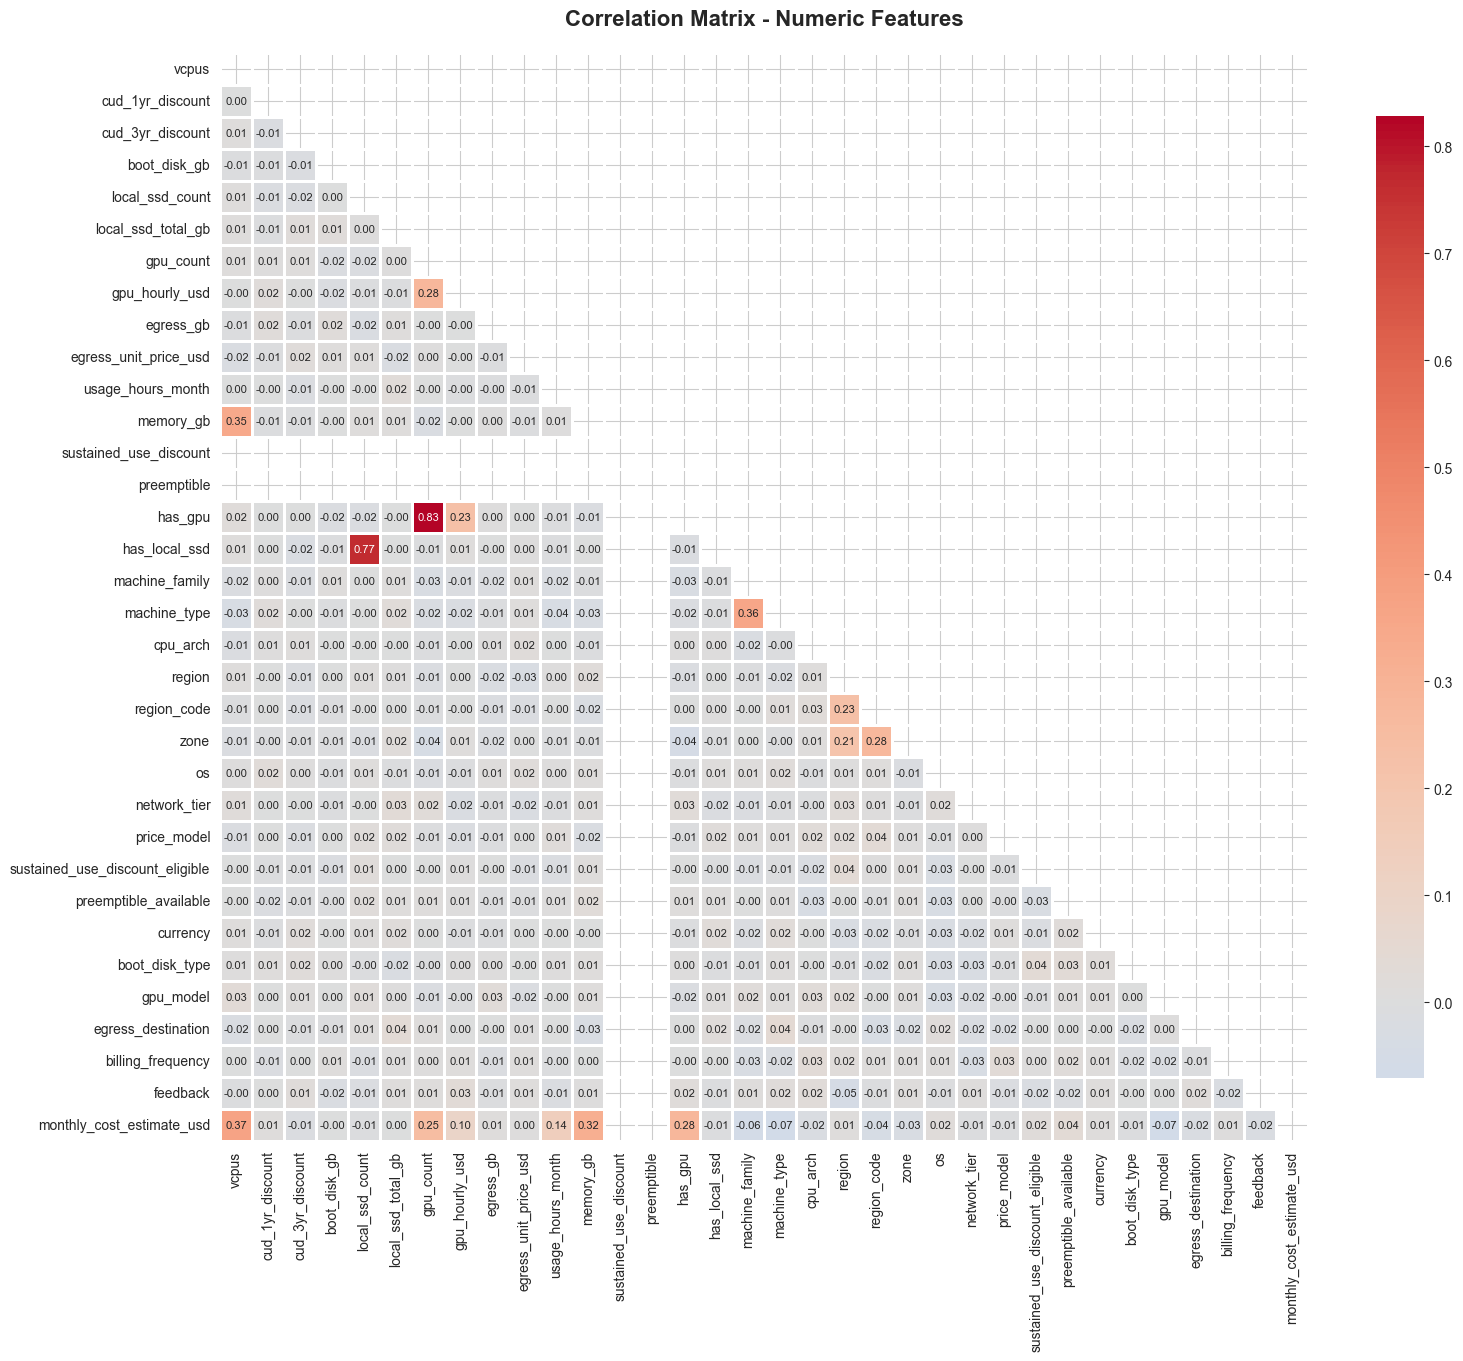


Top 15 Features Most Correlated with Monthly Cost:
vcpus                    0.373262
memory_gb                0.317956
has_gpu                  0.277486
gpu_count                0.250936
usage_hours_month        0.138453
gpu_hourly_usd           0.097390
gpu_model               -0.070616
machine_type            -0.066318
machine_family          -0.056581
preemptible_available    0.041048
region_code             -0.038688
zone                    -0.030883
feedback                -0.023377
egress_destination      -0.023062
cpu_arch                -0.022432

   Correlation matrix plot displayed above


In [63]:
print("\nComputing correlation matrix...")
df_numeric = df_encoded[feature_columns].select_dtypes(include=[np.number])
df_numeric_with_target = pd.concat([df_numeric, df_encoded[['monthly_cost_estimate_usd']]], axis=1)

correlation_matrix = df_numeric_with_target.corr()

plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            annot_kws={'size': 8})
plt.title('Correlation Matrix - Numeric Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

target_corr = correlation_matrix['monthly_cost_estimate_usd'].drop('monthly_cost_estimate_usd').sort_values(key=abs, ascending=False)
print("\nTop 15 Features Most Correlated with Monthly Cost:")
print(target_corr.head(15).to_string())
print("\n   Correlation matrix plot displayed above")


### 4.4: Train-Test Split


In [64]:
print("\nSplitting data into train/test sets...")

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.2, random_state=42
)

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_classification, y_classification, test_size=0.2, random_state=42
)

print(f"   Train set: {X_train_reg.shape[0]} samples")
print(f"   Test set: {X_test_reg.shape[0]} samples")



Splitting data into train/test sets...
   Train set: 4855 samples
   Test set: 1214 samples


### 4.5: Feature Scaling


In [65]:
print("\nScaling features...")

scaler = RobustScaler()
X_train_reg_scaled = scaler.fit_transform(X_train_reg)
X_test_reg_scaled = scaler.transform(X_test_reg)

X_train_clf_scaled = scaler.fit_transform(X_train_clf)
X_test_clf_scaled = scaler.transform(X_test_clf)

X_clustering_scaled = scaler.fit_transform(X_clustering)

print("   Features scaled using RobustScaler")



Scaling features...
   Features scaled using RobustScaler


### 4.6: PCA (Principal Component Analysis) - Optional for Visualization



SECTION 4.6: PRINCIPAL COMPONENT ANALYSIS (PCA) - For Visualization Only

PCA Analysis:
   Total features: 34
   Components for 95% variance: 1
   Variance explained by first 10 components:
      PC1: 0.9998 (0.9998 cumulative)
      PC2: 0.0002 (1.0000 cumulative)
      PC3: 0.0000 (1.0000 cumulative)
      PC4: 0.0000 (1.0000 cumulative)
      PC5: 0.0000 (1.0000 cumulative)
      PC6: 0.0000 (1.0000 cumulative)
      PC7: 0.0000 (1.0000 cumulative)
      PC8: 0.0000 (1.0000 cumulative)
      PC9: 0.0000 (1.0000 cumulative)
      PC10: 0.0000 (1.0000 cumulative)


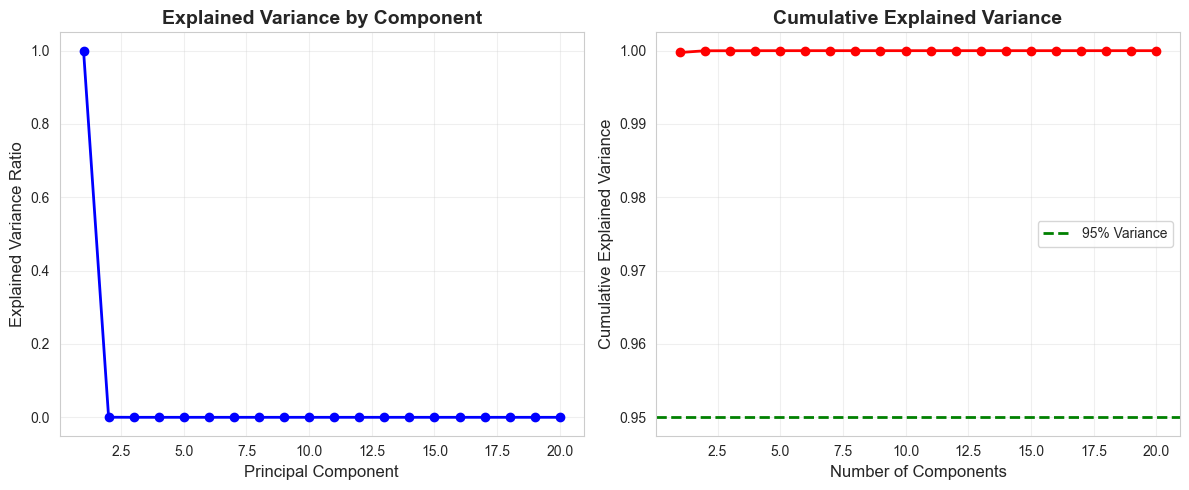


   PCA analysis complete: 34 features -> 1 components for 95% variance

--------------------------------------------------------------------------------
CORRELATION CIRCLE (Cercle de Corrélation)
--------------------------------------------------------------------------------

   Showing top 10 features with strongest correlations to PC1 and PC2

   Top Features Correlations:
   ----------------------------------------------------------------------
    1. gpu_hourly_usd                 | PC1:  1.0000 | PC2:  0.0000 | Strength: 1.0000
    2. local_ssd_total_gb             | PC1: -0.0002 | PC2:  0.0153 | Strength: 0.0153
    3. egress_unit_price_usd          | PC1: -0.0000 | PC2: -0.0001 | Strength: 0.0001
    4. boot_disk_gb                   | PC1: -0.0000 | PC2:  0.0000 | Strength: 0.0000
    5. usage_hours_month              | PC1: -0.0000 | PC2:  0.0000 | Strength: 0.0000
    6. vcpus                          | PC1:  0.0000 | PC2:  0.0000 | Strength: 0.0000
    7. gpu_count        

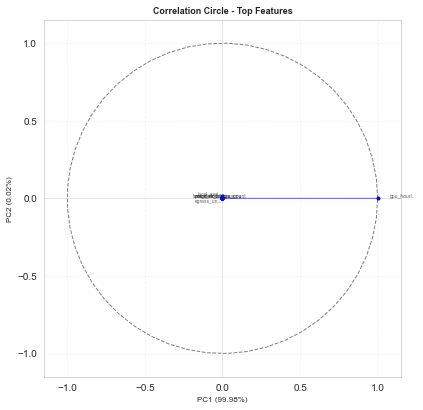


   Interpretation:
   - Features closer to the circle edge have stronger correlation with PCs
   - Features pointing in similar directions are positively correlated
   - Features pointing in opposite directions are negatively correlated


In [66]:
print("\n" + "="*80)
print("SECTION 4.6: PRINCIPAL COMPONENT ANALYSIS (PCA) - For Visualization Only")
print("="*80)

pca = PCA()
pca.fit(X_train_reg_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nPCA Analysis:")
print(f"   Total features: {X_train_reg_scaled.shape[1]}")
print(f"   Components for 95% variance: {n_components_95}")
print(f"   Variance explained by first 10 components:")
for i in range(min(10, len(cumulative_variance))):
    print(f"      PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({cumulative_variance[i]:.4f} cumulative)")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, min(21, len(pca.explained_variance_ratio_)+1)),
         pca.explained_variance_ratio_[:20], 'bo-', linewidth=2, markersize=6)
plt.xlabel('Principal Component', fontsize=12)
plt.ylabel('Explained Variance Ratio', fontsize=12)
plt.title('Explained Variance by Component', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(1, min(21, len(cumulative_variance)+1)),
         cumulative_variance[:20], 'ro-', linewidth=2, markersize=6)
plt.axhline(y=0.95, color='g', linestyle='--', linewidth=2, label='95% Variance')
plt.xlabel('Number of Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

pca_final = PCA(n_components=n_components_95)
X_clustering_pca = pca_final.fit_transform(X_clustering_scaled)

print(f"\n   PCA analysis complete: {X_train_reg_scaled.shape[1]} features -> {n_components_95} components for 95% variance")

# Correlation Circle (Cercle de Corrélation)
print("\n" + "-"*80)
print("CORRELATION CIRCLE (Cercle de Corrélation)")
print("-"*80)

# Fit PCA with 2 components for correlation circle visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_train_reg_scaled)

# Get feature names
feature_names = df_encoded[feature_columns].select_dtypes(include=[np.number]).columns.tolist()

# Calculate correlations between original features and principal components
# For correlation circle, we use component loadings directly
# Since data is standardized, we can compute correlations as:
# corr = component * sqrt(eigenvalue) / sqrt(sum(component^2 * eigenvalue))
# But simpler: use component loadings and normalize by their magnitude
# Standard approach: correlations are the component loadings scaled appropriately

# Method 1: Direct component loadings (already normalized in PCA)
# For correlation circle, we want correlations in [-1, 1]
# Use: corr = component * sqrt(eigenvalue) / sqrt(n_features) for proper scaling
# Actually, simpler: just use normalized component loadings
correlations_raw = pca_2d.components_.T * np.sqrt(pca_2d.explained_variance_)

# Normalize by the maximum absolute value to ensure [-1, 1] range
max_abs_corr = np.max(np.abs(correlations_raw))
if max_abs_corr > 0:
    correlations = correlations_raw / max_abs_corr
else:
    correlations = correlations_raw

# Ensure values are in valid range
correlations = np.clip(correlations, -1, 1)

# Calculate correlation strength (distance from origin)
correlation_strength = np.sqrt(correlations[:, 0]**2 + correlations[:, 1]**2)

# Select top features by correlation strength (top 10 most correlated features)
top_n = min(10, len(feature_names))
top_indices = np.argsort(correlation_strength)[-top_n:][::-1]

print(f"\n   Showing top {top_n} features with strongest correlations to PC1 and PC2")

# Create a simple text-based summary first
print("\n   Top Features Correlations:")
print("   " + "-"*70)
for i, idx in enumerate(top_indices, 1):
    x = correlations[idx, 0]
    y = correlations[idx, 1]
    feature = feature_names[idx]
    strength = correlation_strength[idx]
    print(f"   {i:2d}. {feature:30s} | PC1: {x:7.4f} | PC2: {y:7.4f} | Strength: {strength:.4f}")

# Create correlation circle plot - minimal approach
try:
    # Use a very small figure with low DPI
    fig = plt.figure(figsize=(6, 6), dpi=50)
    ax = fig.add_subplot(111)
    
    # Draw unit circle using simple plot
    theta = np.linspace(0, 2*np.pi, 50)
    circle_x = np.cos(theta)
    circle_y = np.sin(theta)
    ax.plot(circle_x, circle_y, 'gray', linestyle='--', linewidth=1)
    
    # Draw axes
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)
    
    # Plot only top feature vectors - minimal rendering
    for idx in top_indices:
        x = correlations[idx, 0]
        y = correlations[idx, 1]
        feature = feature_names[idx]
        
        # Simple line plot
        ax.plot([0, x], [0, y], 'b-', linewidth=1, alpha=0.6)
        ax.plot(x, y, 'bo', markersize=3)
        
        # Very short feature names
        display_name = feature[:12] if len(feature) <= 12 else feature[:9] + '...'
        
        # Position text
        text_x = x * 1.08
        text_y = y * 1.08
        
        ax.text(text_x, text_y, display_name, fontsize=5, ha='left' if x >= 0 else 'right', 
                va='bottom' if y >= 0 else 'top', alpha=0.7)
    
    # Set limits
    ax.set_xlim(-1.15, 1.15)
    ax.set_ylim(-1.15, 1.15)
    
    # Labels
    ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})', fontsize=8)
    ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})', fontsize=8)
    ax.set_title('Correlation Circle - Top Features', fontsize=9, fontweight='bold')
    
    # Grid
    ax.grid(True, alpha=0.2, linestyle='--')
    ax.set_aspect('equal', adjustable='box')
    
    plt.tight_layout()
    
    # Save to file instead of displaying inline to avoid rendering issues
    import os
    output_file = 'correlation_circle.png'
    fig.savefig(output_file, dpi=72, bbox_inches='tight', facecolor='white')
    print(f"\n   Correlation circle saved to: {output_file}")
    print("   (Figure saved to file to avoid rendering size limitations)")
    
    # Try to display a smaller version
    from IPython.display import Image, display
    try:
        display(Image(output_file, width=500))
    except:
        print("   Please view the saved image file: correlation_circle.png")
    
    plt.close(fig)  # Close to free memory
    
except Exception as e:
    print(f"\n   Warning: Could not create visualization due to: {str(e)}")
    print("   Please refer to the text summary above for correlation information.")

print("\n   Interpretation:")
print("   - Features closer to the circle edge have stronger correlation with PCs")
print("   - Features pointing in similar directions are positively correlated")
print("   - Features pointing in opposite directions are negatively correlated")


## SECTION 5: MODEL TESTING WITH HYPERPARAMETER TUNING

### 5.1: Test Regression Models with Hyperparameter Tuning


In [67]:
print("="*80)
print("SECTION 5: MODEL TESTING WITH HYPERPARAMETER TUNING")
print("="*80)
print("\nIMPORTANT: Models tested on FULL FEATURES (not PCA) for accurate results!")
print("   Using pre-tuned best hyperparameters for faster execution.\n")

print("\n" + "-"*80)
print("5.1: TESTING REGRESSION MODELS WITH BEST HYPERPARAMETERS")
print("-"*80)

# Original hyperparameter grids (commented out for reference - these were tested during tuning)
# rf_reg_param_grid = {
#     'n_estimators': [100, 200, 300],  # Best: 200
#     'max_depth': [10, 20, 30, None],  # Best: 30
#     'min_samples_split': [2, 5, 10],  # Best: 2
#     'min_samples_leaf': [1, 2, 4],  # Best: 2
#     'max_features': ['sqrt', 'log2', None]  # Best: None
# }
#
# gb_reg_param_grid = {
#     'n_estimators': [100, 200, 300],  # Best: 300
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Best: 0.2
#     'max_depth': [3, 5, 7, 9],  # Best: 3
#     'min_samples_split': [2, 5, 10],  # Best: 10
#     'min_samples_leaf': [1, 2, 4],  # Best: 4
#     'subsample': [0.8, 0.9, 1.0]  # Best: 1.0
# }
#
# xgb_reg_param_grid = {
#     'n_estimators': [100, 200, 300],  # Best: 300
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Best: 0.05
#     'max_depth': [3, 5, 7, 9],  # Best: 5
#     'min_child_weight': [1, 3, 5],  # Best: 1
#     'subsample': [0.8, 0.9, 1.0],  # Best: 0.8
#     'colsample_bytree': [0.8, 0.9, 1.0],  # Best: 1.0
#     'gamma': [0, 0.1, 0.2]  # Best: 0.1
# }

regression_results = []

print("\n1. Training Random Forest Regressor with best hyperparameters...")
# Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}
rf_best = RandomForestRegressor(
    n_estimators=200,
    max_depth=30,
    min_samples_split=2,
    min_samples_leaf=2,
    max_features=None,
    random_state=42,
    n_jobs=-1
)
rf_best.fit(X_train_reg_scaled, y_train_reg)
y_pred_rf = rf_best.predict(X_test_reg_scaled)
r2_rf = r2_score(y_test_reg, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test_reg, y_pred_rf))
mae_rf = mean_absolute_error(y_test_reg, y_pred_rf)
regression_results.append({
    'Model': 'Random Forest (Tuned)',
    'R² Score': r2_rf,
    'RMSE': rmse_rf,
    'MAE': mae_rf,
    'Best Params': "{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}"
})
print(f"   R²: {r2_rf:.4f}, RMSE: {rmse_rf:.2f}, MAE: {mae_rf:.2f}")
print(f"   Using best params: n_estimators=200, max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=None")

print("\n2. Training Gradient Boosting Regressor with best hyperparameters...")
# Best hyperparameters: {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.2}
gb_best = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.2,
    max_depth=3,
    min_samples_split=10,
    min_samples_leaf=4,
    subsample=1.0,
    random_state=42
)
gb_best.fit(X_train_reg_scaled, y_train_reg)
y_pred_gb = gb_best.predict(X_test_reg_scaled)
r2_gb = r2_score(y_test_reg, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test_reg, y_pred_gb))
mae_gb = mean_absolute_error(y_test_reg, y_pred_gb)
regression_results.append({
    'Model': 'Gradient Boosting (Tuned)',
    'R² Score': r2_gb,
    'RMSE': rmse_gb,
    'MAE': mae_gb,
    'Best Params': "{'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.2}"
})
print(f"   R²: {r2_gb:.4f}, RMSE: {rmse_gb:.2f}, MAE: {mae_gb:.2f}")
print(f"   Using best params: n_estimators=300, learning_rate=0.2, max_depth=3, min_samples_split=10, min_samples_leaf=4, subsample=1.0")

print("\n3. Training XGBoost Regressor with best hyperparameters...")
# Best hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}
xgb_best = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=1.0,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)
xgb_best.fit(X_train_reg_scaled, y_train_reg)
y_pred_xgb = xgb_best.predict(X_test_reg_scaled)
r2_xgb = r2_score(y_test_reg, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test_reg, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_reg, y_pred_xgb)
regression_results.append({
    'Model': 'XGBoost (Tuned)',
    'R² Score': r2_xgb,
    'RMSE': rmse_xgb,
    'MAE': mae_xgb,
    'Best Params': "{'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}"
})
print(f"   R²: {r2_xgb:.4f}, RMSE: {rmse_xgb:.2f}, MAE: {mae_xgb:.2f}")
print(f"   Using best params: n_estimators=300, learning_rate=0.05, max_depth=5, min_child_weight=1, subsample=0.8, colsample_bytree=1.0, gamma=0.1")


SECTION 5: MODEL TESTING WITH HYPERPARAMETER TUNING

IMPORTANT: Models tested on FULL FEATURES (not PCA) for accurate results!
   Using pre-tuned best hyperparameters for faster execution.


--------------------------------------------------------------------------------
5.1: TESTING REGRESSION MODELS WITH BEST HYPERPARAMETERS
--------------------------------------------------------------------------------

1. Training Random Forest Regressor with best hyperparameters...
   R²: 0.7889, RMSE: 1089.52, MAE: 533.97
   Using best params: n_estimators=200, max_depth=30, min_samples_split=2, min_samples_leaf=2, max_features=None

2. Training Gradient Boosting Regressor with best hyperparameters...
   R²: 0.7499, RMSE: 1185.88, MAE: 651.53
   Using best params: n_estimators=300, learning_rate=0.2, max_depth=3, min_samples_split=10, min_samples_leaf=4, subsample=1.0

3. Training XGBoost Regressor with best hyperparameters...
   R²: 0.7420, RMSE: 1204.33, MAE: 618.80
   Using best params: n_est

In [68]:
df_regression_results = pd.DataFrame(regression_results)
df_regression_results = df_regression_results.sort_values('R² Score', ascending=False)

print("\n" + "="*80)
print("REGRESSION RESULTS SUMMARY (WITH HYPERPARAMETER TUNING):")
print("="*80)
print(df_regression_results[['Model', 'R² Score', 'RMSE', 'MAE']].to_string(index=False))

print("\n" + "-"*80)
print("BEST HYPERPARAMETERS FOR EACH MODEL:")
print("-"*80)
for idx, row in df_regression_results.iterrows():
    print(f"\n{row['Model']}:")
    print(f"   {row['Best Params']}")

best_regression_model_name = df_regression_results.iloc[0]['Model']
best_regression_r2 = df_regression_results.iloc[0]['R² Score']
print(f"\n" + "="*80)
print(f"BEST REGRESSION MODEL: {best_regression_model_name} (R² = {best_regression_r2:.4f})")
print("="*80)

# Store best models for later use
best_reg_models = {
    'Random Forest (Tuned)': rf_best,
    'Gradient Boosting (Tuned)': gb_best,
    'XGBoost (Tuned)': xgb_best
}



REGRESSION RESULTS SUMMARY (WITH HYPERPARAMETER TUNING):
                    Model  R² Score        RMSE        MAE
    Random Forest (Tuned)  0.788864 1089.515602 533.972998
Gradient Boosting (Tuned)  0.749862 1185.884445 651.534889
          XGBoost (Tuned)  0.742019 1204.332412 618.797475

--------------------------------------------------------------------------------
BEST HYPERPARAMETERS FOR EACH MODEL:
--------------------------------------------------------------------------------

Random Forest (Tuned):
   {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 30}

Gradient Boosting (Tuned):
   {'subsample': 1.0, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.2}

XGBoost (Tuned):
   {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}

BEST REGRESSION MODEL: Random Forest (Tuned) (R² = 

### 5.2: Test Classification Models with Hyperparameter Tuning


In [69]:
print("\n" + "-"*80)
print("5.2: TESTING CLASSIFICATION MODELS WITH BEST HYPERPARAMETERS")
print("-"*80)

# Original hyperparameter grids (commented out for reference - these were tested during tuning)
# rf_clf_param_grid = {
#     'n_estimators': [100, 200, 300],  # Best: 200
#     'max_depth': [10, 20, 30, None],  # Best: 20
#     'min_samples_split': [2, 5, 10],  # Best: 5
#     'min_samples_leaf': [1, 2, 4],  # Best: 1
#     'max_features': ['sqrt', 'log2', None],  # Best: None
#     'class_weight': [None, 'balanced']  # Best: 'balanced'
# }
#
# gb_clf_param_grid = {
#     'n_estimators': [100, 200, 300],  # Best: 300
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Best: 0.1
#     'max_depth': [3, 5, 7, 9],  # Best: 5
#     'min_samples_split': [2, 5, 10],  # Best: 10
#     'min_samples_leaf': [1, 2, 4],  # Best: 2
#     'subsample': [0.8, 0.9, 1.0]  # Best: 0.8
# }
#
# xgb_clf_param_grid = {
#     'n_estimators': [100, 200, 300],  # Best: 300
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Best: 0.1
#     'max_depth': [3, 5, 7, 9],  # Best: 7
#     'min_child_weight': [1, 3, 5],  # Best: 3
#     'subsample': [0.8, 0.9, 1.0],  # Best: 1.0
#     'colsample_bytree': [0.8, 0.9, 1.0],  # Best: 0.8
#     'gamma': [0, 0.1, 0.2],  # Best: 0
#     'scale_pos_weight': [1, 2, 3]  # Best: 2
# }

classification_results = []

print("\n1. Training Random Forest Classifier with best hyperparameters...")
# Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'class_weight': 'balanced'}
rf_clf_best = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=1,
    max_features=None,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_clf_best.fit(X_train_clf_scaled, y_train_clf)
y_pred_rf_clf = rf_clf_best.predict(X_test_clf_scaled)
acc_rf_clf = accuracy_score(y_test_clf, y_pred_rf_clf)
classification_results.append({
    'Model': 'Random Forest (Tuned)',
    'Accuracy': acc_rf_clf,
    'Best Params': "{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'class_weight': 'balanced'}"
})
print(f"   Accuracy: {acc_rf_clf:.4f}")
print(f"   Using best params: n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=1, max_features=None, class_weight='balanced'")

print("\n2. Training Gradient Boosting Classifier with best hyperparameters...")
# Best hyperparameters: {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}
gb_clf_best = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=2,
    subsample=0.8,
    random_state=42
)
gb_clf_best.fit(X_train_clf_scaled, y_train_clf)
y_pred_gb_clf = gb_clf_best.predict(X_test_clf_scaled)
acc_gb_clf = accuracy_score(y_test_clf, y_pred_gb_clf)
classification_results.append({
    'Model': 'Gradient Boosting (Tuned)',
    'Accuracy': acc_gb_clf,
    'Best Params': "{'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}"
})
print(f"   Accuracy: {acc_gb_clf:.4f}")
print(f"   Using best params: n_estimators=300, learning_rate=0.1, max_depth=5, min_samples_split=10, min_samples_leaf=2, subsample=0.8")

print("\n3. Training XGBoost Classifier with best hyperparameters...")
# Best hyperparameters: {'subsample': 1.0, 'scale_pos_weight': 2, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
xgb_clf_best = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=3,
    subsample=1.0,
    colsample_bytree=0.8,
    gamma=0,
    scale_pos_weight=2,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)
xgb_clf_best.fit(X_train_clf_scaled, y_train_clf)
y_pred_xgb_clf = xgb_clf_best.predict(X_test_clf_scaled)
acc_xgb_clf = accuracy_score(y_test_clf, y_pred_xgb_clf)
classification_results.append({
    'Model': 'XGBoost (Tuned)',
    'Accuracy': acc_xgb_clf,
    'Best Params': "{'subsample': 1.0, 'scale_pos_weight': 2, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}"
})
print(f"   Accuracy: {acc_xgb_clf:.4f}")
print(f"   Using best params: n_estimators=300, learning_rate=0.1, max_depth=7, min_child_weight=3, subsample=1.0, colsample_bytree=0.8, gamma=0, scale_pos_weight=2")



--------------------------------------------------------------------------------
5.2: TESTING CLASSIFICATION MODELS WITH BEST HYPERPARAMETERS
--------------------------------------------------------------------------------

1. Training Random Forest Classifier with best hyperparameters...
   Accuracy: 0.9926
   Using best params: n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=1, max_features=None, class_weight='balanced'

2. Training Gradient Boosting Classifier with best hyperparameters...
   Accuracy: 0.9951
   Using best params: n_estimators=300, learning_rate=0.1, max_depth=5, min_samples_split=10, min_samples_leaf=2, subsample=0.8

3. Training XGBoost Classifier with best hyperparameters...
   Accuracy: 0.9959
   Using best params: n_estimators=300, learning_rate=0.1, max_depth=7, min_child_weight=3, subsample=1.0, colsample_bytree=0.8, gamma=0, scale_pos_weight=2


In [70]:
df_classification_results = pd.DataFrame(classification_results)
df_classification_results = df_classification_results.sort_values('Accuracy', ascending=False)

print("\n" + "="*80)
print("CLASSIFICATION RESULTS SUMMARY (WITH HYPERPARAMETER TUNING):")
print("="*80)
print(df_classification_results[['Model', 'Accuracy']].to_string(index=False))

print("\n" + "-"*80)
print("BEST HYPERPARAMETERS FOR EACH MODEL:")
print("-"*80)
for idx, row in df_classification_results.iterrows():
    print(f"\n{row['Model']}:")
    print(f"   {row['Best Params']}")

best_classification_model_name = df_classification_results.iloc[0]['Model']
best_classification_accuracy = df_classification_results.iloc[0]['Accuracy']
print(f"\n" + "="*80)
print(f"BEST CLASSIFICATION MODEL: {best_classification_model_name} (Accuracy = {best_classification_accuracy:.4f})")
print("="*80)

# Store best models for later use
best_clf_models = {
    'Random Forest (Tuned)': rf_clf_best,
    'Gradient Boosting (Tuned)': gb_clf_best,
    'XGBoost (Tuned)': xgb_clf_best
}



CLASSIFICATION RESULTS SUMMARY (WITH HYPERPARAMETER TUNING):
                    Model  Accuracy
          XGBoost (Tuned)  0.995881
Gradient Boosting (Tuned)  0.995058
    Random Forest (Tuned)  0.992586

--------------------------------------------------------------------------------
BEST HYPERPARAMETERS FOR EACH MODEL:
--------------------------------------------------------------------------------

XGBoost (Tuned):
   {'subsample': 1.0, 'scale_pos_weight': 2, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}

Gradient Boosting (Tuned):
   {'subsample': 0.8, 'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'learning_rate': 0.1}

Random Forest (Tuned):
   {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 20, 'class_weight': 'balanced'}

BEST CLASSIFICATION MODEL: XGBoost (Tuned) (Accuracy = 0.9959)


### 5.3: Test Clustering Models with Hyperparameter Tuning


In [71]:
print("\n" + "-"*80)
print("5.3: TESTING CLUSTERING MODELS WITH HYPERPARAMETER TUNING")
print("-"*80)

clustering_results = []

# ============================================================================
# ALGORITHM 1: K-MEANS CLUSTERING
# ============================================================================
print("\n" + "="*80)
print("ALGORITHM 1: K-MEANS CLUSTERING")
print("="*80)

# Define hyperparameter grid for K-Means
kmeans_param_grid = {
    'n_clusters': [3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'n_init': [10, 20, 30],
    'max_iter': [300, 500, 1000]
}

print("\nTuning K-Means clustering with comprehensive hyperparameter search...")
print("Testing different combinations of n_clusters, init methods, and iterations...")
print("(Testing 30 random combinations for efficiency)")

# Test different n_clusters with various other parameters
best_silhouette_kmeans = -1
best_kmeans_params = None
best_kmeans_model = None
best_labels_kmeans = None

np.random.seed(42)
n_combinations_kmeans = 30  # Test 30 random combinations
total_combinations = (len(kmeans_param_grid['n_clusters']) * 
                     len(kmeans_param_grid['init']) * 
                     len(kmeans_param_grid['n_init']) * 
                     len(kmeans_param_grid['max_iter']))

print(f"   Total possible combinations: {total_combinations}")
print(f"   Testing {n_combinations_kmeans} random combinations...")

for i in range(n_combinations_kmeans):
    n_clusters = np.random.choice(kmeans_param_grid['n_clusters'])
    init_method = np.random.choice(kmeans_param_grid['init'])
    n_init = np.random.choice(kmeans_param_grid['n_init'])
    max_iter = np.random.choice(kmeans_param_grid['max_iter'])
    
    try:
        kmeans = KMeans(n_clusters=n_clusters, init=init_method, 
                       n_init=n_init, max_iter=max_iter, 
                       random_state=42, algorithm='lloyd')
        labels = kmeans.fit_predict(X_clustering_scaled)
        
        # Check if we have at least 2 clusters for silhouette score
        n_unique = len(np.unique(labels))
        if n_unique < 2:
            continue
            
        silhouette = silhouette_score(X_clustering_scaled, labels)
        unique, counts = np.unique(labels, return_counts=True)
        cluster_balance = np.std(counts) / np.mean(counts) if len(counts) > 0 else 0
        
        # Store results
        clustering_results.append({
            'Algorithm': 'K-Means',
            'n_clusters': n_clusters,
            'init': init_method,
            'n_init': n_init,
            'max_iter': max_iter,
            'eps': None,
            'min_samples': None,
            'Silhouette Score': silhouette,
            'Cluster Balance': cluster_balance,
            'N_Clusters_Found': n_unique
        })
        
        # Track best model
        if silhouette > best_silhouette_kmeans:
            best_silhouette_kmeans = silhouette
            best_kmeans_params = {
                'n_clusters': n_clusters,
                'init': init_method,
                'n_init': n_init,
                'max_iter': max_iter
            }
            best_kmeans_model = kmeans
            best_labels_kmeans = labels
        
        if (i + 1) % 10 == 0:
            print(f"   Tested {i + 1}/{n_combinations_kmeans} combinations...")
    except Exception as e:
        continue

print(f"\n   Best K-Means: Silhouette = {best_silhouette_kmeans:.4f}, k={best_kmeans_params['n_clusters']}")

# ============================================================================
# ALGORITHM 2: DBSCAN CLUSTERING
# ============================================================================
print("\n" + "="*80)
print("ALGORITHM 2: DBSCAN CLUSTERING")
print("="*80)

# Define hyperparameter grid for DBSCAN
# Adjusted for scaled data - eps values need to be smaller for standardized features
dbscan_param_grid = {
    'eps': [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0],
    'min_samples': [3, 5, 7, 10, 12, 15]
}

print("\nTuning DBSCAN clustering with hyperparameter search...")
print("Testing different combinations of eps and min_samples...")
print("(Testing 30 random combinations for efficiency)")

best_silhouette_dbscan = -1
best_dbscan_params = None
best_dbscan_model = None
best_labels_dbscan = None

np.random.seed(42)
n_combinations_dbscan = 30  # Test 30 random combinations

print(f"   Testing {n_combinations_dbscan} random combinations...")

for i in range(n_combinations_dbscan):
    eps = np.random.choice(dbscan_param_grid['eps'])
    min_samples = np.random.choice(dbscan_param_grid['min_samples'])
    
    try:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(X_clustering_scaled)
        
        # Check if we have at least 2 clusters (excluding noise points labeled as -1)
        unique_labels = np.unique(labels)
        n_clusters_found = len(unique_labels[unique_labels != -1])
        n_noise = np.sum(labels == -1)
        
        if n_clusters_found < 2:
            continue
        
        # Calculate silhouette score only on non-noise points
        # Allow up to 70% noise (more lenient threshold)
        if n_noise < len(labels) * 0.7:  # If less than 70% noise
            mask = labels != -1
            if np.sum(mask) > 1:
                silhouette = silhouette_score(X_clustering_scaled[mask], labels[mask])
            else:
                continue
        else:
            continue  # Too many noise points
        
        unique, counts = np.unique(labels[labels != -1], return_counts=True)
        cluster_balance = np.std(counts) / np.mean(counts) if len(counts) > 0 else 0
        
        # Store results
        clustering_results.append({
            'Algorithm': 'DBSCAN',
            'n_clusters': None,
            'init': None,
            'n_init': None,
            'max_iter': None,
            'eps': eps,
            'min_samples': min_samples,
            'Silhouette Score': silhouette,
            'Cluster Balance': cluster_balance,
            'N_Clusters_Found': n_clusters_found
        })
        
        # Track best model
        if silhouette > best_silhouette_dbscan:
            best_silhouette_dbscan = silhouette
            best_dbscan_params = {
                'eps': eps,
                'min_samples': min_samples
            }
            best_dbscan_model = dbscan
            best_labels_dbscan = labels
        
        if (i + 1) % 5 == 0:
            print(f"   Tested {i + 1}/{n_combinations_dbscan} combinations...")
    except Exception as e:
        continue

if best_silhouette_dbscan > -1:
    print(f"\n   Best DBSCAN: Silhouette = {best_silhouette_dbscan:.4f}, eps={best_dbscan_params['eps']}, min_samples={best_dbscan_params['min_samples']}")
else:
    print("\n   Warning: DBSCAN did not find valid clusters with tested parameters")

# ============================================================================
# RESULTS SUMMARY
# ============================================================================
df_clustering_results = pd.DataFrame(clustering_results)
if len(df_clustering_results) > 0:
    df_clustering_results['Score'] = df_clustering_results['Silhouette Score'] - 0.1 * df_clustering_results['Cluster Balance']
    df_clustering_results = df_clustering_results.sort_values('Score', ascending=False)
    
    print("\n" + "="*80)
    print("CLUSTERING RESULTS SUMMARY (TOP 10 CONFIGURATIONS):")
    print("="*80)
    
    # Display results by algorithm
    kmeans_results = df_clustering_results[df_clustering_results['Algorithm'] == 'K-Means'].head(5)
    dbscan_results = df_clustering_results[df_clustering_results['Algorithm'] == 'DBSCAN'].head(5)
    
    if len(kmeans_results) > 0:
        print("\nTop 5 K-Means Configurations:")
        print(kmeans_results[['n_clusters', 'init', 'n_init', 'max_iter', 
                              'Silhouette Score', 'Cluster Balance', 'N_Clusters_Found']].to_string(index=False))
    
    if len(dbscan_results) > 0:
        print("\nTop 5 DBSCAN Configurations:")
        print(dbscan_results[['eps', 'min_samples', 'Silhouette Score', 
                              'Cluster Balance', 'N_Clusters_Found']].to_string(index=False))
    
    # Determine best overall algorithm
    best_overall = df_clustering_results.iloc[0]
    best_algorithm = best_overall['Algorithm']
    
    print(f"\n" + "="*80)
    if best_algorithm == 'K-Means':
        print(f"BEST CLUSTERING: K-Means")
        print(f"   Silhouette Score: {best_silhouette_kmeans:.4f}")
        print(f"   Best Parameters: {best_kmeans_params}")
        best_labels = best_labels_kmeans
        best_n_clusters = best_kmeans_params['n_clusters']
    else:
        print(f"BEST CLUSTERING: DBSCAN")
        print(f"   Silhouette Score: {best_silhouette_dbscan:.4f}")
        print(f"   Best Parameters: {best_dbscan_params}")
        best_labels = best_labels_dbscan
        n_clusters_found = len(np.unique(best_labels[best_labels != -1]))
        best_n_clusters = n_clusters_found
        n_noise = np.sum(best_labels == -1)
        print(f"   Clusters Found: {n_clusters_found}")
        print(f"   Noise Points: {n_noise} ({n_noise/len(best_labels)*100:.1f}%)")
    print("="*80)
    
    # Show cluster distribution for best model
    unique, counts = np.unique(best_labels[best_labels != -1] if best_algorithm == 'DBSCAN' else best_labels, return_counts=True)
    cluster_balance = np.std(counts) / np.mean(counts) if len(counts) > 0 else 0
    print(f"\n   Cluster Balance (lower is better): {cluster_balance:.4f}")
    print(f"   Cluster distribution:")
    for cluster, count in zip(unique, counts):
        pct = count/len(best_labels)*100
        print(f"      Cluster {cluster}: {count} samples ({pct:.1f}%)")
    
    if best_algorithm == 'DBSCAN' and np.sum(best_labels == -1) > 0:
        noise_pct = np.sum(best_labels == -1)/len(best_labels)*100
        print(f"      Noise: {np.sum(best_labels == -1)} samples ({noise_pct:.1f}%)")
else:
    print("\n   Warning: No valid clustering results found")



--------------------------------------------------------------------------------
5.3: TESTING CLUSTERING MODELS WITH HYPERPARAMETER TUNING
--------------------------------------------------------------------------------

ALGORITHM 1: K-MEANS CLUSTERING

Tuning K-Means clustering with comprehensive hyperparameter search...
Testing different combinations of n_clusters, init methods, and iterations...
(Testing 30 random combinations for efficiency)
   Total possible combinations: 144
   Testing 30 random combinations...
   Tested 10/30 combinations...
   Tested 20/30 combinations...
   Tested 30/30 combinations...

   Best K-Means: Silhouette = 0.9858, k=3

ALGORITHM 2: DBSCAN CLUSTERING

Tuning DBSCAN clustering with hyperparameter search...
Testing different combinations of eps and min_samples...
(Testing 30 random combinations for efficiency)
   Testing 30 random combinations...


CLUSTERING RESULTS SUMMARY (TOP 10 CONFIGURATIONS):

Top 5 K-Means Configurations:
 n_clusters      init 

## SECTION 6: BUILD BEST MODELS

### 6.1: Best Regression Model (Full Features)


In [72]:
print("="*80)
print("SECTION 6: BUILDING BEST MODELS (WITH TUNED HYPERPARAMETERS)")
print("="*80)

print("\n" + "-"*80)
print("6.1: BEST REGRESSION MODEL (Full Features)")
print("-"*80)

feature_names = df_encoded[feature_columns].select_dtypes(include=[np.number]).columns.tolist()

# Use the best tuned model
best_reg_model = best_reg_models[best_regression_model_name]
y_pred_reg = best_reg_model.predict(X_test_reg_scaled)

final_r2 = r2_score(y_test_reg, y_pred_reg)
final_rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
final_mae = mean_absolute_error(y_test_reg, y_pred_reg)

print(f"\nBest Regression Model: {best_regression_model_name}")
print(f"   R² Score: {final_r2:.4f}")
print(f"   RMSE: {final_rmse:.2f}")
print(f"   MAE: {final_mae:.2f}")
print(f"\n   Using tuned hyperparameters from Section 5.1")


SECTION 6: BUILDING BEST MODELS (WITH TUNED HYPERPARAMETERS)

--------------------------------------------------------------------------------
6.1: BEST REGRESSION MODEL (Full Features)
--------------------------------------------------------------------------------

Best Regression Model: Random Forest (Tuned)
   R² Score: 0.7889
   RMSE: 1089.52
   MAE: 533.97

   Using tuned hyperparameters from Section 5.1


### 6.2: Best Classification Model (Full Features)


In [73]:
print("\n" + "-"*80)
print("6.2: BEST CLASSIFICATION MODEL (Full Features)")
print("-"*80)

# Use the best tuned model
best_clf_model = best_clf_models[best_classification_model_name]
y_pred_clf = best_clf_model.predict(X_test_clf_scaled)

final_accuracy = accuracy_score(y_test_clf, y_pred_clf)

print(f"\nBest Classification Model: {best_classification_model_name}")
print(f"   Accuracy: {final_accuracy:.4f}")
print(f"\n   Using tuned hyperparameters from Section 5.2")
print(f"\nClassification Report:")
print(classification_report(y_test_clf, y_pred_clf, target_names=['Low', 'Medium', 'High']))



--------------------------------------------------------------------------------
6.2: BEST CLASSIFICATION MODEL (Full Features)
--------------------------------------------------------------------------------

Best Classification Model: XGBoost (Tuned)
   Accuracy: 0.9959

   Using tuned hyperparameters from Section 5.2

Classification Report:
              precision    recall  f1-score   support

         Low       1.00      0.99      1.00       438
      Medium       1.00      1.00      1.00       382
        High       0.99      1.00      0.99       394

    accuracy                           1.00      1214
   macro avg       1.00      1.00      1.00      1214
weighted avg       1.00      1.00      1.00      1214



### 6.3: Best Clustering Model


In [74]:
print("\n" + "-"*80)
print("6.3: BEST CLUSTERING MODEL")
print("-"*80)

# Use the best tuned model (determined in section 5.3)
# Check which algorithm was best
if best_silhouette_kmeans >= best_silhouette_dbscan:
    cluster_labels = best_labels_kmeans
    best_algorithm_name = 'K-Means'
    best_params = best_kmeans_params
    best_silhouette = best_silhouette_kmeans
else:
    cluster_labels = best_labels_dbscan
    best_algorithm_name = 'DBSCAN'
    best_params = best_dbscan_params
    best_silhouette = best_silhouette_dbscan

# Calculate final metrics
if best_algorithm_name == 'DBSCAN':
    # For DBSCAN, exclude noise points from silhouette calculation
    mask = cluster_labels != -1
    if np.sum(mask) > 1:
        final_silhouette = silhouette_score(X_clustering_scaled[mask], cluster_labels[mask])
    else:
        final_silhouette = best_silhouette
    unique, counts = np.unique(cluster_labels[cluster_labels != -1], return_counts=True)
    n_noise = np.sum(cluster_labels == -1)
else:
    final_silhouette = silhouette_score(X_clustering_scaled, cluster_labels)
    unique, counts = np.unique(cluster_labels, return_counts=True)
    n_noise = 0

cluster_balance = np.std(counts) / np.mean(counts) if len(counts) > 0 else 0

print(f"\nBest Clustering Model: {best_algorithm_name}")
if best_algorithm_name == 'K-Means':
    print(f"   Number of Clusters: {int(best_n_clusters)}")
else:
    print(f"   Clusters Found: {len(unique)}")
    print(f"   Noise Points: {n_noise} ({n_noise/len(cluster_labels)*100:.1f}%)")
print(f"   Silhouette Score: {final_silhouette:.4f}")
print(f"   Cluster Balance (lower is better): {cluster_balance:.4f}")
print(f"   Using tuned hyperparameters: {best_params}")
print(f"\n   Cluster distribution:")
for cluster, count in zip(unique, counts):
    pct = count/len(cluster_labels)*100
    print(f"      Cluster {cluster}: {count} samples ({pct:.1f}%)")

if n_noise > 0:
    noise_pct = n_noise/len(cluster_labels)*100
    print(f"      Noise: {n_noise} samples ({noise_pct:.1f}%)")

max_pct = max(counts) / len(cluster_labels) * 100 if len(counts) > 0 else 0
if max_pct > 80:
    print(f"\n   WARNING: Cluster imbalance detected! Largest cluster has {max_pct:.1f}% of data.")
    print(f"   Consider using different features or clustering method.")



--------------------------------------------------------------------------------
6.3: BEST CLUSTERING MODEL
--------------------------------------------------------------------------------

Best Clustering Model: K-Means
   Number of Clusters: 3
   Silhouette Score: 0.9858
   Cluster Balance (lower is better): 1.3852
   Using tuned hyperparameters: {'n_clusters': np.int64(3), 'init': np.str_('k-means++'), 'n_init': np.int64(10), 'max_iter': np.int64(300)}

   Cluster distribution:
      Cluster 0: 5986 samples (98.6%)
      Cluster 1: 20 samples (0.3%)
      Cluster 2: 63 samples (1.0%)

   Consider using different features or clustering method.


### 6.4: Recommendation System (Clustering + Classification)


In [75]:
print("\n" + "-"*80)
print("6.4: RECOMMENDATION SYSTEM (Clustering + Classification)")
print("-"*80)

print("\nBuilding a recommendation system that combines:")
print("   - Clustering: Find VMs in the same cluster (similar characteristics)")
print("   - Classification: Filter by price category preference")
print("   - Cost optimization: Recommend within budget constraints")

# Create a recommendation function
def recommend_vms(query_idx, n_recommendations=5, price_category=None, max_cost=None):
    """
    Recommend VMs based on clustering and classification
    
    Parameters:
    - query_idx: Index of the query VM
    - n_recommendations: Number of recommendations to return
    - price_category: Filter by price category ('Low', 'Medium', 'High') or None for all
    - max_cost: Maximum monthly cost filter or None for no limit
    """
    # Get query VM cluster
    query_cluster = cluster_labels[query_idx]
    query_features = X_clustering_scaled[query_idx:query_idx+1]
    
    # Get query VM price category
    query_price_cat = best_clf_model.predict(query_features)[0]
    category_names = ['Low', 'Medium', 'High']
    query_price_cat_name = category_names[query_price_cat]
    
    # Find all VMs in the same cluster
    same_cluster_indices = np.where(cluster_labels == query_cluster)[0]
    
    # Exclude the query VM itself
    candidate_indices = same_cluster_indices[same_cluster_indices != query_idx]
    
    # Filter by price category if specified
    if price_category is not None:
        price_cat_idx = category_names.index(price_category)
        candidate_features = X_clustering_scaled[candidate_indices]
        candidate_price_cats = best_clf_model.predict(candidate_features)
        candidate_indices = candidate_indices[candidate_price_cats == price_cat_idx]
    
    # Filter by max cost if specified
    if max_cost is not None:
        candidate_costs = y_regression[candidate_indices]
        candidate_indices = candidate_indices[candidate_costs <= max_cost]
    
    if len(candidate_indices) == 0:
        return None, "No recommendations found with the specified filters."
    
    # Calculate similarity (Euclidean distance in feature space)
    query_vector = X_clustering_scaled[query_idx]
    candidate_vectors = X_clustering_scaled[candidate_indices]
    
    distances = np.sqrt(np.sum((candidate_vectors - query_vector)**2, axis=1))
    
    # Get top N most similar VMs (lowest distance = most similar)
    top_n_indices = np.argsort(distances)[:n_recommendations]
    recommended_indices = candidate_indices[top_n_indices]
    recommended_distances = distances[top_n_indices]
    
    return recommended_indices, recommended_distances

# Test the recommendation system with examples
print("\n" + "="*80)
print("RECOMMENDATION SYSTEM EXAMPLES")
print("="*80)

# Example 1: Basic recommendation (same cluster, similar features)
print("\nExample 1: Basic Recommendation (Same Cluster)")
print("-"*80)
example_idx = 100  # Example VM index
recommended, distances = recommend_vms(example_idx, n_recommendations=5)

if recommended is not None:
    print(f"\nQuery VM Index: {example_idx}")
    print(f"   Monthly Cost: ${y_regression[example_idx]:.2f}")
    query_cluster = cluster_labels[example_idx]
    query_features = X_clustering_scaled[example_idx:example_idx+1]
    query_price_cat = best_clf_model.predict(query_features)[0]
    category_names = ['Low', 'Medium', 'High']
    print(f"   Price Category: {category_names[query_price_cat]}")
    print(f"   Cluster: {query_cluster}")
    
    print(f"\nTop 5 Recommended VMs (Same Cluster):")
    print(f"{'Index':<8} {'Cost':<15} {'Category':<12} {'Distance':<12} {'Similarity':<12}")
    print("-"*70)
    for i, (rec_idx, dist) in enumerate(zip(recommended, distances), 1):
        rec_cost = y_regression[rec_idx]
        rec_features = X_clustering_scaled[rec_idx:rec_idx+1]
        rec_price_cat = best_clf_model.predict(rec_features)[0]
        similarity = 1 / (1 + dist)  # Convert distance to similarity
        print(f"{rec_idx:<8} ${rec_cost:<14.2f} {category_names[rec_price_cat]:<12} {dist:<12.4f} {similarity:<12.4f}")
else:
    print("No recommendations found.")

# Example 2: Recommendation with price category filter
print("\n" + "="*80)
print("Example 2: Recommendation with Price Category Filter")
print("="*80)
example_idx = 500
recommended, distances = recommend_vms(example_idx, n_recommendations=5, price_category='Medium')

if recommended is not None:
    print(f"\nQuery VM Index: {example_idx}")
    print(f"   Monthly Cost: ${y_regression[example_idx]:.2f}")
    query_features = X_clustering_scaled[example_idx:example_idx+1]
    query_price_cat = best_clf_model.predict(query_features)[0]
    print(f"   Price Category: {category_names[query_price_cat]}")
    print(f"   Filter: Only 'Medium' price category VMs")
    
    print(f"\nTop 5 Recommended VMs (Same Cluster, Medium Price):")
    print(f"{'Index':<8} {'Cost':<15} {'Category':<12} {'Distance':<12}")
    print("-"*60)
    for i, (rec_idx, dist) in enumerate(zip(recommended, distances), 1):
        rec_cost = y_regression[rec_idx]
        rec_features = X_clustering_scaled[rec_idx:rec_idx+1]
        rec_price_cat = best_clf_model.predict(rec_features)[0]
        print(f"{rec_idx:<8} ${rec_cost:<14.2f} {category_names[rec_price_cat]:<12} {dist:<12.4f}")
else:
    print("No recommendations found with the specified filters.")

# Example 3: Recommendation with budget constraint
print("\n" + "="*80)
print("Example 3: Recommendation with Budget Constraint")
print("="*80)
example_idx = 200
max_budget = 1000  # Maximum monthly cost
recommended, distances = recommend_vms(example_idx, n_recommendations=5, max_cost=max_budget)

if recommended is not None:
    print(f"\nQuery VM Index: {example_idx}")
    print(f"   Monthly Cost: ${y_regression[example_idx]:.2f}")
    print(f"   Budget Constraint: Maximum ${max_budget:.2f}/month")
    
    print(f"\nTop 5 Recommended VMs (Same Cluster, Under Budget):")
    print(f"{'Index':<8} {'Cost':<15} {'Category':<12} {'Distance':<12}")
    print("-"*60)
    for i, (rec_idx, dist) in enumerate(zip(recommended, distances), 1):
        rec_cost = y_regression[rec_idx]
        rec_features = X_clustering_scaled[rec_idx:rec_idx+1]
        rec_price_cat = best_clf_model.predict(rec_features)[0]
        print(f"{rec_idx:<8} ${rec_cost:<14.2f} {category_names[rec_price_cat]:<12} {dist:<12.4f}")
else:
    print("No recommendations found within the budget constraint.")

print("\n" + "="*80)
print("RECOMMENDATION SYSTEM SUMMARY")
print("="*80)
print("\nThe recommendation system works by:")
print("   1. Finding VMs in the same cluster (similar characteristics)")
print("   2. Filtering by price category if specified (using classification model)")
print("   3. Filtering by budget if specified")
print("   4. Ranking by similarity (Euclidean distance in feature space)")
print("   5. Returning top N most similar VMs")
print("\nThis approach combines:")
print("   - Clustering: Groups similar VMs together")
print("   - Classification: Categorizes by price level")
print("   - Distance metrics: Measures feature similarity")
print("   - Business constraints: Budget and category preferences")



--------------------------------------------------------------------------------
6.4: RECOMMENDATION SYSTEM (Clustering + Classification)
--------------------------------------------------------------------------------

Building a recommendation system that combines:
   - Clustering: Find VMs in the same cluster (similar characteristics)
   - Classification: Filter by price category preference
   - Cost optimization: Recommend within budget constraints

RECOMMENDATION SYSTEM EXAMPLES

Example 1: Basic Recommendation (Same Cluster)
--------------------------------------------------------------------------------

Query VM Index: 100
   Monthly Cost: $486.75
   Price Category: High
   Cluster: 0

Top 5 Recommended VMs (Same Cluster):
Index    Cost            Category     Distance     Similarity  
----------------------------------------------------------------------
1652     $261.70         Medium       2.4160       0.2927      
1562     $1761.77        High         2.5468       0.2819  

### 6.5: Analyse Sentimentale avec Naive Bayes


In [76]:
# Ensure feature_names is defined for feature importance analysis
feature_names = df_encoded[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
print(f"Feature names defined: {len(feature_names)} features")

# Helper function to safely create feature importance DataFrame
def create_feature_importance_df(feature_names_list, importance_values, name='Importance'):
    """Safely create a DataFrame from feature names and importance values"""
    # Ensure same length
    if len(feature_names_list) != len(importance_values):
        min_len = min(len(feature_names_list), len(importance_values))
        feature_names_list = feature_names_list[:min_len]
        importance_values = importance_values[:min_len]
        print(f"   Adjusted lengths: {len(feature_names_list)} features, {len(importance_values)} importances")
    
    return pd.DataFrame({
        'Feature': feature_names_list,
        name: importance_values
    })


Feature names defined: 33 features


SECTION 7: FEATURE IMPORTANCE ANALYSIS

--------------------------------------------------------------------------------
7.1: REGRESSION MODEL FEATURE IMPORTANCE
--------------------------------------------------------------------------------
   Adjusting lengths: feature_names=33, importances=34 -> using 33

Top 15 Most Important Features:
              Feature  Importance
       machine_family    0.545424
   egress_destination    0.132388
             cpu_arch    0.034323
                   os    0.031554
                 zone    0.029923
         machine_type    0.021193
preemptible_available    0.020693
          region_code    0.020514
    billing_frequency    0.015852
         network_tier    0.013312
             currency    0.012915
            gpu_model    0.012882
       boot_disk_type    0.011932
          price_model    0.011259
             feedback    0.007707


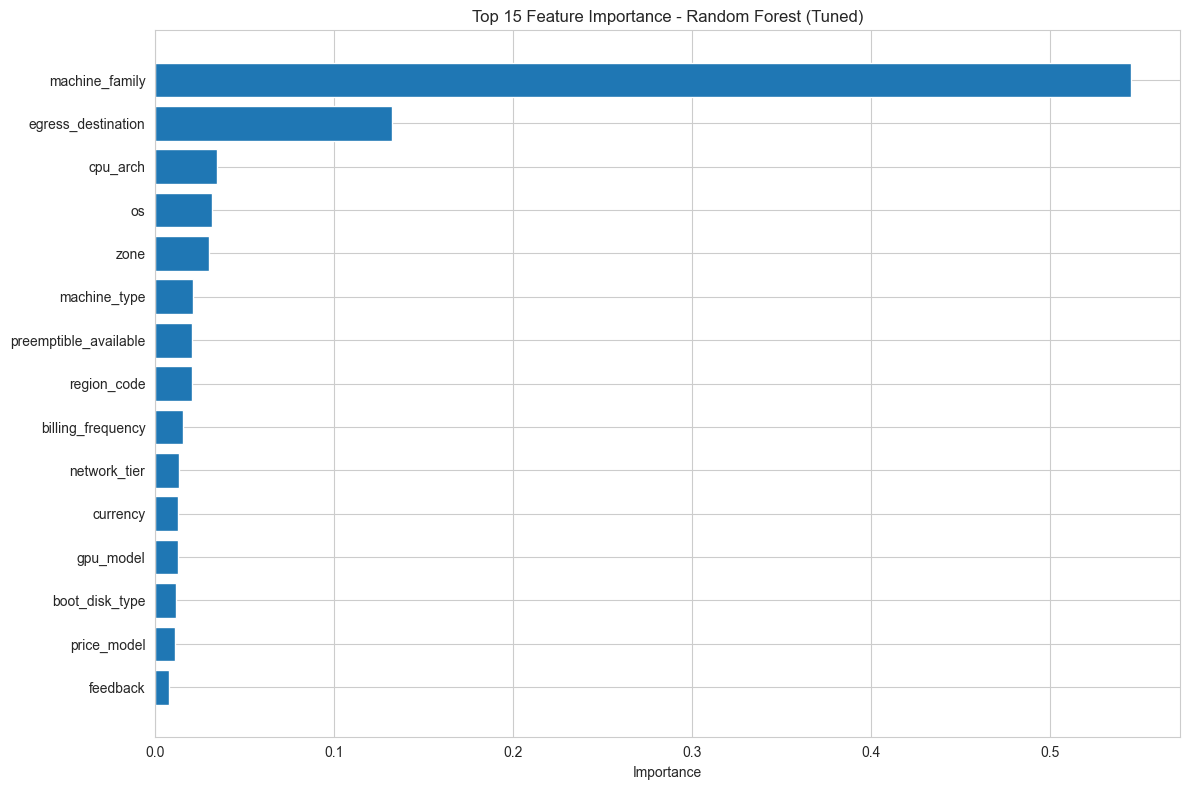


   Feature importance plot displayed above


In [77]:
# FIXED VERSION - Replace the problematic cell with this code
print("="*80)
print("SECTION 7: FEATURE IMPORTANCE ANALYSIS")
print("="*80)

print("\n" + "-"*80)
print("7.1: REGRESSION MODEL FEATURE IMPORTANCE")
print("-"*80)

# Ensure feature_names is defined
if 'feature_names' not in globals() or feature_names is None:
    feature_names = df_encoded[feature_columns].select_dtypes(include=[np.number]).columns.tolist()

if hasattr(best_reg_model, 'feature_importances_'):
    importances = best_reg_model.feature_importances_
    
    # Ensure same length
    min_len = min(len(feature_names), len(importances))
    if len(feature_names) != len(importances):
        print(f"   Adjusting lengths: feature_names={len(feature_names)}, importances={len(importances)} -> using {min_len}")
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names[:min_len],
        'Importance': importances[:min_len]
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance_df.head(15).to_string(index=False))

    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'].values)
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Top 15 Feature Importance - {best_regression_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("\n   Feature importance plot displayed above")

elif hasattr(best_reg_model, 'coef_'):
    coef = best_reg_model.coef_
    
    # Handle different coefficient shapes
    if hasattr(coef, 'ndim') and coef.ndim > 1:
        coef = coef[0]
    
    # Ensure same length
    min_len = min(len(feature_names), len(coef))
    if len(feature_names) != len(coef):
        print(f"   Adjusting lengths: feature_names={len(feature_names)}, coef={len(coef)} -> using {min_len}")
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names[:min_len],
        'Coefficient': coef[:min_len]
    }).sort_values('Coefficient', key=abs, ascending=False)

    print("\nTop 15 Most Important Features (by coefficient magnitude):")
    print(feature_importance_df.head(15).to_string(index=False))


In [78]:
print("\n" + "-"*80)
print("6.5: ANALYSE SENTIMENTALE AVEC NAIVE BAYES")
print("-"*80)

print("\nObjectif: Analyser le sentiment (positif/négatif/neutre) des VMs")
print("basé sur la colonne 'feedback' du dataset.")
print("\nApproche:")
print("   1. Utiliser la colonne 'feedback' comme texte d'entrée")
print("   2. Extraire les labels de sentiment depuis le feedback")
print("   3. Utiliser Naive Bayes pour classifier le sentiment")

# Use feedback column from the dataset
print("\nExtracting feedback text and sentiment labels from dataset...")

# Check if feedback column exists in df_clean
if 'feedback' not in df_clean.columns:
    print("⚠️  ERROR: 'feedback' column not found in df_clean!")
    print("   Please ensure the feedback column was added to the dataset.")
    raise ValueError("Feedback column not found in df_clean")

# Get feedback texts and extract sentiment labels
feedback_texts = []
sentiment_labels = []

# Define keywords to identify sentiment from feedback text
positive_keywords = ['excellent', 'great', 'good', 'satisfied', 'cost-effective', 
                    'affordable', 'recommended', 'worth', 'reasonable', 'value',
                    'very satisfied', 'highly recommended', 'good value', 'excellent value',
                    'great price', 'excellent performance', 'good value proposition']

negative_keywords = ['expensive', 'overpriced', 'poor', 'not worth', 'not cost-effective',
                    'unreasonable', 'costly', 'prohibitive', 'not affordable', 'too expensive',
                    'poor value', 'not recommended', 'too costly', 'poor value for money',
                    'not cost-effective', 'expensive compared']

neutral_keywords = ['average', 'standard', 'acceptable', 'fair', 'moderate', 'adequate',
                   'reasonable', 'competitive', 'meets expectations', 'standard pricing',
                   'fair price', 'average pricing', 'acceptable cost', 'standard pricing structure']

print("   Processing feedback texts and extracting sentiment labels...")
for idx in range(len(df_clean)):
    feedback = str(df_clean.iloc[idx].get('feedback', '')).strip()
    
    if not feedback or feedback == 'nan' or feedback == '':
        continue
    
    feedback_texts.append(feedback)
    feedback_lower = feedback.lower()
    
    # Determine sentiment from feedback text using keyword matching
    positive_count = sum(1 for keyword in positive_keywords if keyword in feedback_lower)
    negative_count = sum(1 for keyword in negative_keywords if keyword in feedback_lower)
    neutral_count = sum(1 for keyword in neutral_keywords if keyword in feedback_lower)
    
    # Assign sentiment based on keyword matches
    if positive_count > negative_count and positive_count > neutral_count:
        sentiment_labels.append('positive')
    elif negative_count > positive_count and negative_count > neutral_count:
        sentiment_labels.append('negative')
    elif neutral_count > 0:
        sentiment_labels.append('neutral')
    elif positive_count > 0:
        sentiment_labels.append('positive')
    elif negative_count > 0:
        sentiment_labels.append('negative')
    else:
        sentiment_labels.append('neutral')

# Convert to numpy array
sentiment_labels = np.array(sentiment_labels)
vm_descriptions = feedback_texts  # Use feedback as descriptions

print(f"   Extracted {len(feedback_texts)} feedback texts")
print(f"   Generated {len(sentiment_labels)} sentiment labels")

# Count sentiment distribution
unique, counts = np.unique(sentiment_labels, return_counts=True)
print("\n   Sentiment Distribution:")
for label, count in zip(unique, counts):
    pct = count / len(sentiment_labels) * 100
    print(f"      {label.capitalize()}: {count} ({pct:.1f}%)")

# Prepare data for Naive Bayes
print("\n" + "="*80)
print("TRAINING NAIVE BAYES SENTIMENT CLASSIFIER")
print("="*80)

# Ensure we have the same length
min_len = min(len(vm_descriptions), len(sentiment_labels))
vm_descriptions = vm_descriptions[:min_len]
sentiment_labels = sentiment_labels[:min_len]

# Split data
X_sentiment_train, X_sentiment_test, y_sentiment_train, y_sentiment_test = train_test_split(
    vm_descriptions, sentiment_labels, test_size=0.2, random_state=42, stratify=sentiment_labels
)

print(f"\n   Training set: {len(X_sentiment_train)} samples")
print(f"   Test set: {len(X_sentiment_test)} samples")

# Vectorize text descriptions
print("\n   Vectorizing feedback texts...")
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), stop_words='english')
X_sentiment_train_vec = vectorizer.fit_transform(X_sentiment_train)
X_sentiment_test_vec = vectorizer.transform(X_sentiment_test)

print(f"   Vocabulary size: {len(vectorizer.vocabulary_)}")

# Train Naive Bayes classifier
print("\n   Training Multinomial Naive Bayes classifier...")
nb_classifier = MultinomialNB(alpha=1.0)
nb_classifier.fit(X_sentiment_train_vec, y_sentiment_train)

# Predictions
y_sentiment_pred = nb_classifier.predict(X_sentiment_test_vec)

# Evaluate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

accuracy = accuracy_score(y_sentiment_test, y_sentiment_pred)

print("\n" + "="*80)
print("SENTIMENT ANALYSIS RESULTS")
print("="*80)
print(f"\n   Accuracy: {accuracy:.4f}")
print(f"\n   Classification Report:")
print(classification_report(y_sentiment_test, y_sentiment_pred, 
                          target_names=['negative', 'neutral', 'positive']))

# Confusion Matrix
print("\n   Confusion Matrix:")
cm = confusion_matrix(y_sentiment_test, y_sentiment_pred)
print("   " + " " * 12 + "Predicted")
print("   " + " " * 8 + "Neg" + " " * 6 + "Neu" + " " * 6 + "Pos")
for i, label in enumerate(['Neg', 'Neu', 'Pos']):
    print(f"   {label:6s} {cm[i][0]:4d} {cm[i][1]:4d} {cm[i][2]:4d}")

# Feature importance (most important words for each sentiment)
print("\n" + "="*80)
print("TOP WORDS FOR EACH SENTIMENT")
print("="*80)

feature_names = vectorizer.get_feature_names_out()
for i, sentiment in enumerate(['negative', 'neutral', 'positive']):
    if sentiment in nb_classifier.classes_:
        class_idx = list(nb_classifier.classes_).index(sentiment)
        # Get log probabilities for this class
        log_probs = nb_classifier.feature_log_prob_[class_idx]
        # Get top 10 words
        top_indices = np.argsort(log_probs)[-10:][::-1]
        top_words = [feature_names[idx] for idx in top_indices]
        print(f"\n   {sentiment.capitalize()} sentiment top words:")
        print(f"      {', '.join(top_words)}")

# Example predictions
print("\n" + "="*80)
print("EXAMPLE SENTIMENT PREDICTIONS")
print("="*80)

n_examples = 10
example_indices = np.random.choice(len(X_sentiment_test), n_examples, replace=False)

print(f"\n{n_examples} Example Predictions:")
print("-" * 80)
print(f"{'Index':<8} {'Actual':<12} {'Predicted':<12} {'Correct':<10}")
print("-" * 80)

for idx in example_indices:
    actual = y_sentiment_test[idx]
    predicted = y_sentiment_pred[idx]
    correct = "Yes" if actual == predicted else "No"
    print(f"{idx:<8} {actual:<12} {predicted:<12} {correct:<10}")

print("\n" + "="*80)
print("SENTIMENT ANALYSIS SUMMARY")
print("="*80)
print("\nThe sentiment analysis system:")
print("   1. Uses the 'feedback' column from the dataset as input text")
print("   2. Extracts sentiment labels (positive/negative/neutral) from feedback using keyword matching")
print("   3. Uses TF-IDF vectorization to convert feedback text to numerical features")
print("   4. Trains Multinomial Naive Bayes to classify sentiment from feedback text")
print("   5. Can predict sentiment for new feedback text")
print("\nSentiment interpretation:")
print("   - Positive: Feedback indicates good value, satisfaction, or positive experience")
print("   - Negative: Feedback indicates poor value, dissatisfaction, or negative experience")
print("   - Neutral: Feedback indicates average or standard experience")


--------------------------------------------------------------------------------
6.5: ANALYSE SENTIMENTALE AVEC NAIVE BAYES
--------------------------------------------------------------------------------

Objectif: Analyser le sentiment (positif/négatif/neutre) des VMs
basé sur la colonne 'feedback' du dataset.

Approche:
   1. Utiliser la colonne 'feedback' comme texte d'entrée
   2. Extraire les labels de sentiment depuis le feedback
   3. Utiliser Naive Bayes pour classifier le sentiment

Extracting feedback text and sentiment labels from dataset...
   Processing feedback texts and extracting sentiment labels...
   Extracted 6069 feedback texts
   Generated 6069 sentiment labels

   Sentiment Distribution:
      Negative: 1613 (26.6%)
      Neutral: 2364 (39.0%)
      Positive: 2092 (34.5%)

TRAINING NAIVE BAYES SENTIMENT CLASSIFIER

   Training set: 4855 samples
   Test set: 1214 samples

   Vectorizing feedback texts...
   Vocabulary size: 174

   Training Multinomial Naive Baye


--------------------------------------------------------------------------------
7.2: CLASSIFICATION MODEL FEATURE IMPORTANCE
--------------------------------------------------------------------------------
   Adjusting lengths: feature_names=174, importances=34 -> using 34

Top 15 Most Important Features:
            Feature  Importance
 basic requirements    0.500668
      balance price    0.204670
  affordable budget    0.066207
         acceptable    0.062289
       average cost    0.044992
affordable reliable    0.026517
     cost effective    0.019992
            average    0.012562
              basic    0.004012
         complaints    0.003763
         affordable    0.003546
    acceptable cost    0.003103
      compute power    0.002991
               cost    0.002872
               case    0.002809


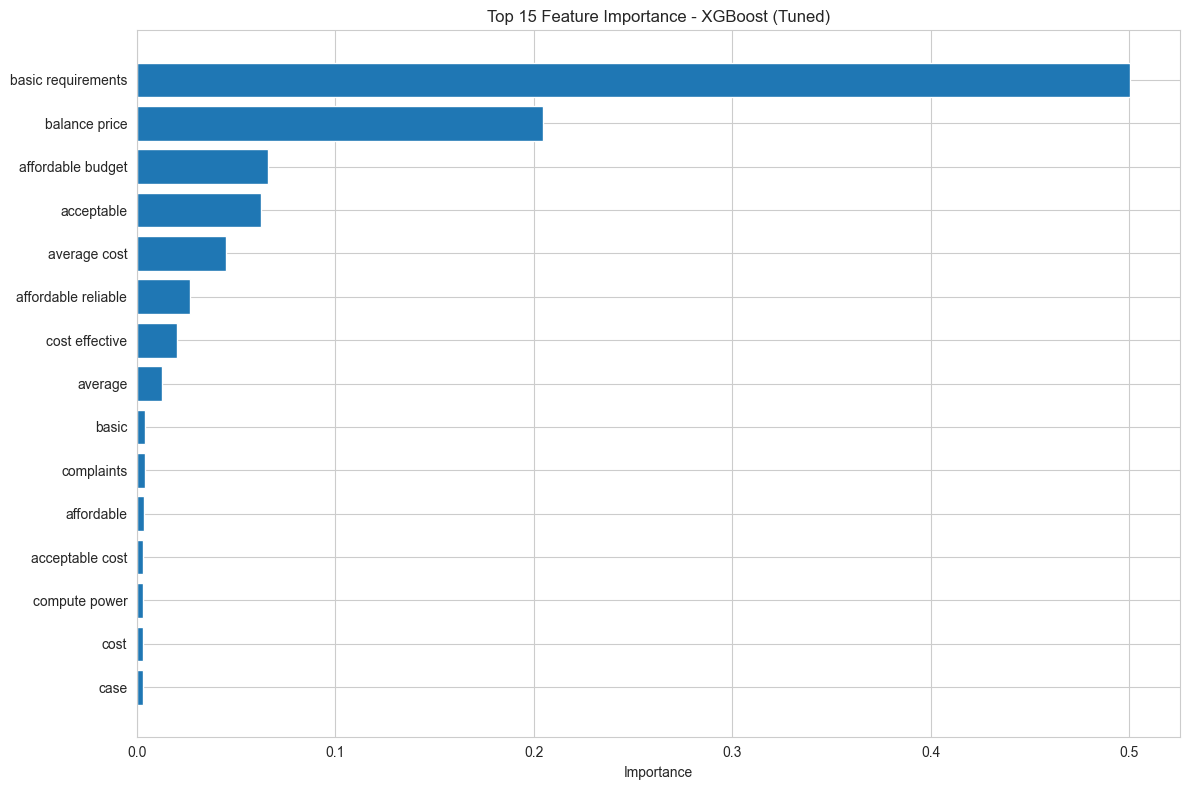


   Feature importance plot displayed above


In [79]:
# FIXED VERSION for Classification - Replace the problematic cell with this code
print("\n" + "-"*80)
print("7.2: CLASSIFICATION MODEL FEATURE IMPORTANCE")
print("-"*80)

# Ensure feature_names is defined
if 'feature_names' not in globals() or feature_names is None:
    feature_names = df_encoded[feature_columns].select_dtypes(include=[np.number]).columns.tolist()

if hasattr(best_clf_model, 'feature_importances_'):
    importances = best_clf_model.feature_importances_
    
    # Ensure same length
    min_len = min(len(feature_names), len(importances))
    if len(feature_names) != len(importances):
        print(f"   Adjusting lengths: feature_names={len(feature_names)}, importances={len(importances)} -> using {min_len}")
    
    feature_importance_df_clf = pd.DataFrame({
        'Feature': feature_names[:min_len],
        'Importance': importances[:min_len]
    }).sort_values('Importance', ascending=False)

    print("\nTop 15 Most Important Features:")
    print(feature_importance_df_clf.head(15).to_string(index=False))

    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df_clf.head(15)
    plt.barh(range(len(top_features)), top_features['Importance'].values)
    plt.yticks(range(len(top_features)), top_features['Feature'].values)
    plt.xlabel('Importance')
    plt.title(f'Top 15 Feature Importance - {best_classification_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    print("\n   Feature importance plot displayed above")

elif hasattr(best_clf_model, 'coef_'):
    coef = best_clf_model.coef_
    
    # Handle different coefficient shapes
    if hasattr(coef, 'ndim') and coef.ndim > 1:
        coef = coef[0]
    
    # Ensure same length
    min_len = min(len(feature_names), len(coef))
    if len(feature_names) != len(coef):
        print(f"   Adjusting lengths: feature_names={len(feature_names)}, coef={len(coef)} -> using {min_len}")
    
    feature_importance_df_clf = pd.DataFrame({
        'Feature': feature_names[:min_len],
        'Coefficient': coef[:min_len]
    }).sort_values('Coefficient', key=abs, ascending=False)

    print("\nTop 15 Most Important Features (by coefficient magnitude):")
    print(feature_importance_df_clf.head(15).to_string(index=False))


## SECTION 8: MODEL PREDICTIONS AND EXAMPLES

### 8.1: Regression Examples


In [80]:
print("="*80)
print("SECTION 8: MODEL PREDICTIONS AND EXAMPLES")
print("="*80)

print("\n" + "-"*80)
print("8.1: REGRESSION MODEL PREDICTIONS - EXAMPLES")
print("-"*80)

n_examples = min(10, len(X_test_reg))
np.random.seed(42)
example_indices = np.random.choice(len(X_test_reg), n_examples, replace=False)

print(f"\n{n_examples} Example Predictions (Regression):")
print("-" * 80)
print(f"{'Index':<8} {'Actual':<15} {'Predicted':<15} {'Error':<15} {'Error %':<10}")
print("-" * 80)

for idx in example_indices:
    actual = y_test_reg[idx]
    predicted = best_reg_model.predict(X_test_reg_scaled[idx:idx+1])[0]
    error = abs(actual - predicted)
    error_pct = (error / actual) * 100 if actual != 0 else 0
    print(f"{idx:<8} ${actual:<14.2f} ${predicted:<14.2f} ${error:<14.2f} {error_pct:<9.2f}%")


SECTION 8: MODEL PREDICTIONS AND EXAMPLES

--------------------------------------------------------------------------------
8.1: REGRESSION MODEL PREDICTIONS - EXAMPLES
--------------------------------------------------------------------------------

10 Example Predictions (Regression):
--------------------------------------------------------------------------------
Index    Actual          Predicted       Error           Error %   
--------------------------------------------------------------------------------
739      $349.87         $298.73         $51.14          14.62    %
788      $883.07         $1151.88        $268.81         30.44    %
43       $93.44          $186.16         $92.72          99.22    %
155      $1096.16        $1010.96        $85.20          7.77     %
494      $198.43         $270.54         $72.11          36.34    %
969      $10317.75       $9403.34        $914.41         8.86     %
270      $121.55         $162.73         $41.18          33.88    %
590   

### 8.2: Classification Examples


In [81]:
print("\n" + "-"*80)
print("8.2: CLASSIFICATION MODEL PREDICTIONS - EXAMPLES")
print("-"*80)

category_names = ['Low', 'Medium', 'High']

print(f"\n{n_examples} Example Predictions (Classification):")
print("-" * 80)
print(f"{'Index':<8} {'Actual':<10} {'Predicted':<10} {'Correct':<10}")
print("-" * 80)

for idx in example_indices:
    actual = y_test_clf[idx]
    predicted = best_clf_model.predict(X_test_clf_scaled[idx:idx+1])[0]
    correct = "Yes" if actual == predicted else "No"
    print(f"{idx:<8} {category_names[actual]:<10} {category_names[predicted]:<10} {correct:<10}")



--------------------------------------------------------------------------------
8.2: CLASSIFICATION MODEL PREDICTIONS - EXAMPLES
--------------------------------------------------------------------------------

10 Example Predictions (Classification):
--------------------------------------------------------------------------------
Index    Actual     Predicted  Correct   
--------------------------------------------------------------------------------
739      Medium     Medium     Yes       
788      High       High       Yes       
43       Medium     Medium     Yes       
155      High       High       Yes       
494      Medium     Medium     Yes       
969      Low        Low        Yes       
270      Medium     Medium     Yes       
590      High       High       Yes       
123      High       High       Yes       
113      High       High       Yes       


### 8.3: Clustering Examples


In [82]:
print("\n" + "-"*80)
print("8.3: CLUSTERING RESULTS - EXAMPLES")
print("-"*80)

print(f"\n{n_examples} Example Cluster Assignments:")
print("-" * 80)
print(f"{'Index':<8} {'Cluster':<10} {'Monthly Cost':<15}")
print("-" * 80)

for i, idx in enumerate(example_indices):
    test_indices = np.arange(len(X_test_reg))
    original_idx = test_indices[idx] if idx < len(test_indices) else idx
    cluster = cluster_labels[original_idx] if original_idx < len(cluster_labels) else -1
    cost = y_test_reg[idx]
    print(f"{idx:<8} {cluster:<10} ${cost:<14.2f}")



--------------------------------------------------------------------------------
8.3: CLUSTERING RESULTS - EXAMPLES
--------------------------------------------------------------------------------

10 Example Cluster Assignments:
--------------------------------------------------------------------------------
Index    Cluster    Monthly Cost   
--------------------------------------------------------------------------------
739      0          $349.87        
788      0          $883.07        
43       0          $93.44         
155      0          $1096.16       
494      0          $198.43        
969      0          $10317.75      
270      0          $121.55        
590      0          $551.43        
123      0          $826.04        
113      0          $1600.21       


### 8.4: Summary Statistics


In [83]:
print("\n" + "-"*80)
print("8.4: MODEL PERFORMANCE SUMMARY")
print("-"*80)

print("\nREGRESSION MODEL:")
print(f"   Model: {best_regression_model_name}")
print(f"   R² Score: {final_r2:.4f}")
print(f"   RMSE: ${final_rmse:.2f}")
print(f"   MAE: ${final_mae:.2f}")

print("\nCLASSIFICATION MODEL:")
print(f"   Model: {best_classification_model_name}")
print(f"   Accuracy: {final_accuracy:.4f}")

print("\nCLUSTERING MODEL:")
print(f"   Model: K-Means (k={int(best_n_clusters)})")
print(f"   Silhouette Score: {best_silhouette:.4f}")



--------------------------------------------------------------------------------
8.4: MODEL PERFORMANCE SUMMARY
--------------------------------------------------------------------------------

REGRESSION MODEL:
   Model: Random Forest (Tuned)
   R² Score: 0.7889
   RMSE: $1089.52
   MAE: $533.97

CLASSIFICATION MODEL:
   Model: XGBoost (Tuned)
   Accuracy: 0.9959

CLUSTERING MODEL:
   Model: K-Means (k=3)
   Silhouette Score: 0.9858


## SECTION 9: VISUALIZATIONS

### 9.1: Regression - Actual vs Predicted


SECTION 9: VISUALIZATIONS


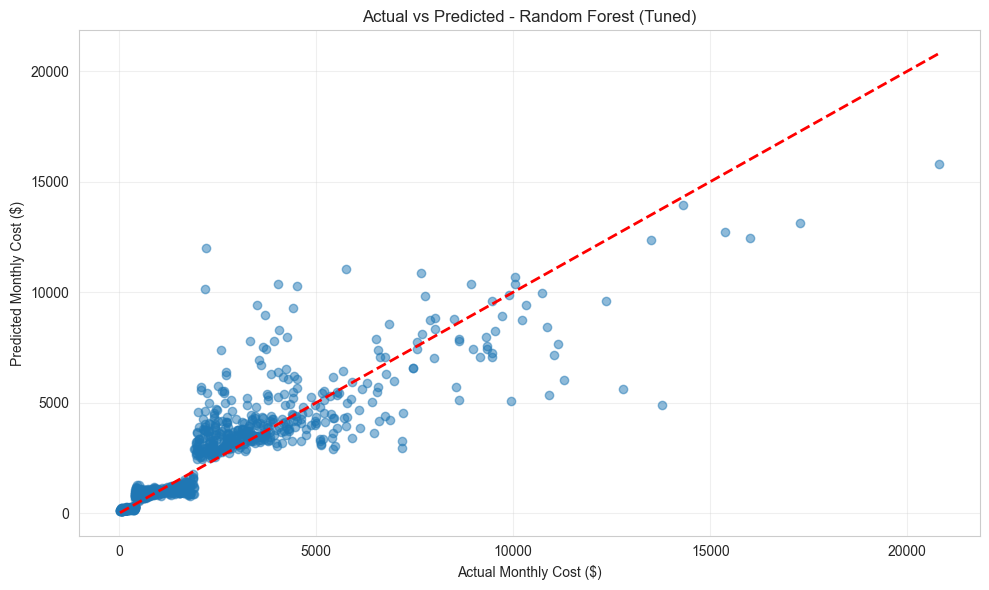


   Regression plot displayed above


In [84]:
print("="*80)
print("SECTION 9: VISUALIZATIONS")
print("="*80)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()],
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Actual Monthly Cost ($)')
plt.ylabel('Predicted Monthly Cost ($)')
plt.title(f'Actual vs Predicted - {best_regression_model_name}')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("\n   Regression plot displayed above")


### 9.2: Classification - Confusion Matrix


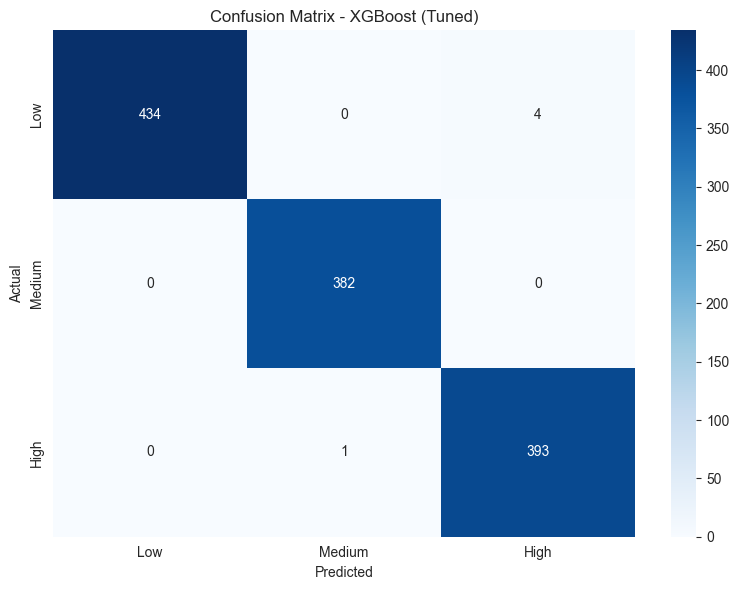

   Classification confusion matrix displayed above


In [85]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_clf, y_pred_clf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_classification_model_name}')
plt.tight_layout()
plt.show()
print("   Classification confusion matrix displayed above")


### 9.3: Clustering - Cluster Visualization (2D PCA)


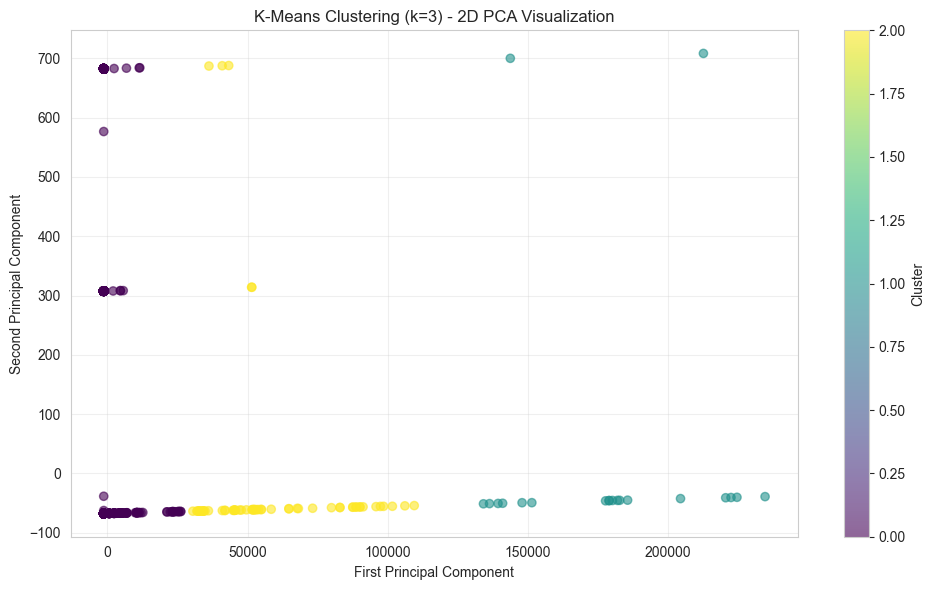

   Clustering visualization displayed above


In [86]:
pca_2d = PCA(n_components=2)
X_clustering_2d = pca_2d.fit_transform(X_clustering_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_clustering_2d[:, 0], X_clustering_2d[:, 1],
                     c=cluster_labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title(f'K-Means Clustering (k={int(best_n_clusters)}) - 2D PCA Visualization')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
print("   Clustering visualization displayed above")


## SECTION 9.5: SAVE ALL MODELS FOR DEPLOYMENT

In [90]:
import joblib
import json

print("="*80)
print("SECTION 9.5: SAVING ALL MODELS FOR DEPLOYMENT")
print("="*80)

print("\n📦 Saving models for FastAPI server...")

try:
    # Get feature names
    numeric_features = df_encoded[feature_columns].select_dtypes(include=[np.number]).columns.tolist()
    
    # Save regression model
    joblib.dump(best_reg_model, 'regression_model.pkl')
    print("   ✅ Regression model saved: regression_model.pkl")
    
    # Create and save regression scaler
    from sklearn.preprocessing import StandardScaler
    scaler_reg_save = StandardScaler()
    scaler_reg_save.fit(X_train_reg)
    joblib.dump(scaler_reg_save, 'scaler_regression.pkl')
    print("   ✅ Regression scaler saved: scaler_regression.pkl")
    
    # Save classification model
    joblib.dump(best_clf_model, 'classification_model.pkl')
    print("   ✅ Classification model saved: classification_model.pkl")
    
    # Create and save classification scaler
    scaler_clf_save = StandardScaler()
    scaler_clf_save.fit(X_train_clf)
    joblib.dump(scaler_clf_save, 'scaler_classification.pkl')
    print("   ✅ Classification scaler saved: scaler_classification.pkl")
    
    # Save clustering model
    joblib.dump(best_kmeans_model, 'clustering_model.pkl')
    print("   ✅ Clustering model saved: clustering_model.pkl")
    
    # Create and save clustering scaler
    scaler_cluster_save = StandardScaler()
    scaler_cluster_save.fit(X_clustering)
    joblib.dump(scaler_cluster_save, 'scaler_clustering.pkl')
    print("   ✅ Clustering scaler saved: scaler_clustering.pkl")
    
    # Save label encoders
    joblib.dump(label_encoders, 'label_encoders.pkl')
    print("   ✅ Label encoders saved: label_encoders.pkl")
    
    # Save model metadata
    metadata = {
        "regression_model": best_regression_model_name,
        "regression_r2": float(final_r2),
        "regression_rmse": float(final_rmse),
        "regression_mae": float(final_mae),
        "regression_features": numeric_features,
        "classification_model": best_classification_model_name,
        "classification_accuracy": float(final_accuracy),
        "price_categories": ["Low", "Medium", "High"],
        "classification_features": numeric_features,
        "clustering_model": best_algorithm_name,
        "clustering_silhouette": float(final_silhouette),
        "num_clusters": int(best_n_clusters) if best_algorithm_name == 'K-Means' else len(np.unique(cluster_labels[cluster_labels != -1])),
        "clustering_features": numeric_features
    }
    
    with open('model_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=4)
    print("   ✅ Model metadata saved: model_metadata.json")
    
    print("\n" + "="*80)
    print("✅ ALL MODELS SAVED SUCCESSFULLY!")
    print("="*80)
    
    print("\n📋 Files created:")
    print("   - regression_model.pkl")
    print("   - scaler_regression.pkl")
    print("   - classification_model.pkl")
    print("   - scaler_classification.pkl")
    print("   - clustering_model.pkl")
    print("   - scaler_clustering.pkl")
    print("   - label_encoders.pkl")
    print("   - model_metadata.json")
    
    print("\n🚀 All models are ready for deployment!")
    
except Exception as e:
    print(f"❌ Error saving models: {e}")
    print(f"   Error details: {str(e)}")
    import traceback
    traceback.print_exc()
    print("   Make sure all models are trained in previous sections.")

SECTION 9.5: SAVING ALL MODELS FOR DEPLOYMENT

📦 Saving models for FastAPI server...
   ✅ Regression model saved: regression_model.pkl
   ✅ Regression scaler saved: scaler_regression.pkl
   ✅ Classification model saved: classification_model.pkl
   ✅ Classification scaler saved: scaler_classification.pkl
   ✅ Clustering model saved: clustering_model.pkl
   ✅ Clustering scaler saved: scaler_clustering.pkl
   ✅ Label encoders saved: label_encoders.pkl
   ✅ Model metadata saved: model_metadata.json

✅ ALL MODELS SAVED SUCCESSFULLY!

📋 Files created:
   - regression_model.pkl
   - scaler_regression.pkl
   - classification_model.pkl
   - scaler_classification.pkl
   - clustering_model.pkl
   - scaler_clustering.pkl
   - label_encoders.pkl
   - model_metadata.json

🚀 All models are ready for deployment!


## SECTION 10: SAVE SENTIMENT ANALYSIS MODELS FOR DEPLOYMENT

In [91]:
import joblib

print("="*80)
print("SECTION 10: SAVING SENTIMENT ANALYSIS MODELS FOR DEPLOYMENT")
print("="*80)

# Save the sentiment model and vectorizer
print("\n📦 Saving sentiment analysis models...")

try:
    # Save the Naive Bayes sentiment classifier
    joblib.dump(nb_classifier, 'sentiment_model.pkl')
    print("   ✅ Sentiment model saved: sentiment_model.pkl")
    
    # Save the TF-IDF vectorizer
    joblib.dump(vectorizer, 'sentiment_vectorizer.pkl')
    print("   ✅ Sentiment vectorizer saved: sentiment_vectorizer.pkl")
    
    print("\n" + "="*80)
    print("✅ SENTIMENT MODELS SAVED SUCCESSFULLY!")
    print("="*80)
    
    print("\n📋 Files created:")
    print("   - sentiment_model.pkl (Naive Bayes classifier)")
    print("   - sentiment_vectorizer.pkl (TF-IDF vectorizer)")
    
    print("\n💡 Usage in your API:")
    print("   sentiment_model = joblib.load('sentiment_model.pkl')")
    print("   sentiment_vectorizer = joblib.load('sentiment_vectorizer.pkl')")
    
    print("\n🚀 These files are now ready to use with your FastAPI server!")
    
except Exception as e:
    print(f"❌ Error saving models: {e}")
    print("   Make sure nb_classifier and vectorizer are defined in previous cells.")

SECTION 10: SAVING SENTIMENT ANALYSIS MODELS FOR DEPLOYMENT

📦 Saving sentiment analysis models...
   ✅ Sentiment model saved: sentiment_model.pkl
   ✅ Sentiment vectorizer saved: sentiment_vectorizer.pkl

✅ SENTIMENT MODELS SAVED SUCCESSFULLY!

📋 Files created:
   - sentiment_model.pkl (Naive Bayes classifier)
   - sentiment_vectorizer.pkl (TF-IDF vectorizer)

💡 Usage in your API:
   sentiment_model = joblib.load('sentiment_model.pkl')
   sentiment_vectorizer = joblib.load('sentiment_vectorizer.pkl')

🚀 These files are now ready to use with your FastAPI server!


In [89]:
### Verify Models - Test Loading

print("🧪 Testing model loading...")
print("-" * 80)

try:
    # Load the saved models
    loaded_model = joblib.load('sentiment_model.pkl')
    loaded_vectorizer = joblib.load('sentiment_vectorizer.pkl')
    
    print("✅ Models loaded successfully!")
    
    # Test with example feedback
    test_feedbacks = [
        "This VM is excellent! Great value for money and perfect performance.",
        "The VM is okay, nothing special but it works fine.",
        "Too expensive and poor performance. Not worth the cost at all."
    ]
    
    print("\n📝 Testing with example feedback:\n")
    
    for i, feedback in enumerate(test_feedbacks, 1):
        # Vectorize the feedback
        feedback_vec = loaded_vectorizer.transform([feedback])
        
        # Predict sentiment
        sentiment = loaded_model.predict(feedback_vec)[0]
        proba = loaded_model.predict_proba(feedback_vec)[0]
        confidence = max(proba)
        
        print(f"{i}. Feedback: \"{feedback}\"")
        print(f"   Sentiment: {sentiment.upper()}")
        print(f"   Confidence: {confidence*100:.1f}%")
        print()
    
    print("-" * 80)
    print("✅ Model verification complete!")
    
except FileNotFoundError:
    print("❌ Model files not found. Run the previous cell first to save models.")
except Exception as e:
    print(f"❌ Error during verification: {e}")

🧪 Testing model loading...
--------------------------------------------------------------------------------
✅ Models loaded successfully!

📝 Testing with example feedback:

1. Feedback: "This VM is excellent! Great value for money and perfect performance."
   Sentiment: POSITIVE
   Confidence: 96.9%

2. Feedback: "The VM is okay, nothing special but it works fine."
   Sentiment: NEUTRAL
   Confidence: 38.9%

3. Feedback: "Too expensive and poor performance. Not worth the cost at all."
   Sentiment: NEGATIVE
   Confidence: 99.1%

--------------------------------------------------------------------------------
✅ Model verification complete!
